# Exploratory Data Analysis

In [44]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

# Global Path Variables
PARENT_DIRECTORY = os.pardir

# Global Paths to Data Folders
RAW_DATA_FOLDER = os.path.join(PARENT_DIRECTORY, os.path.join('data', 'raw'))
PROCESSED_DATA_FOLDER = os.path.join(PARENT_DIRECTORY, os.path.join('data', 'processed'))

## Load all the data

In [45]:
# Mobility Data
google_mobility_data_NY_cleaned = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, 'google_mobility_data.csv')).iloc[:, 1:]

# Weather data
df_weather = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, 'weather_data.csv'))

# Influenza target data
df_target = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, 'influenza_case_data.csv'))

# Population Data
pop_df = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, 'population_2018192021_clean.csv'))

## Mobility Data

In [46]:
def plot_every_feature_for_county(county):
    """Returns a figure that represents a plot of every feature in the google mobility
       data over time for the specified county. 

    Args:
        county (str): specified county name

    Returns:
        fig (matplotlib.figure.Figure): figure containing the resulting plot
    """
    feat_names = ['Retail and \nRecreation', 'Grocery and \nPharmacy', 'Parks', 'Transit \nStations', 'Work', 'Residential']
    colors = ['blue', 'green', 'red', 'pink', 'purple', 'orange']
    
    # Ensure all the dates are present for each county
    county_data = google_mobility_data_NY_cleaned[google_mobility_data_NY_cleaned['county'] == county]
        
    # Plot the features
    fig = plt.figure()
    
    plt.plot(county_data['date'], [0]*county_data.shape[0], label='Baseline', color='black', linewidth=2)
    for i, (feat, name) in enumerate(zip(county_data.columns[3:], feat_names)):
        plt.plot(county_data['date'], county_data[feat], label=name, color=colors[i])
        
    plt.xlabel('Date')
    plt.ylabel('% Change from Baseline')
    plt.title(f'Mobility Changes for {county}')
    plt.legend(loc='right', ncol=1, shadow=True, bbox_to_anchor=(1.28, .5))
    plt.xticks(rotation=90)
    
    # Only keep every 8th tick
    for i, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
        if(i % 8 == 0):
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    return fig

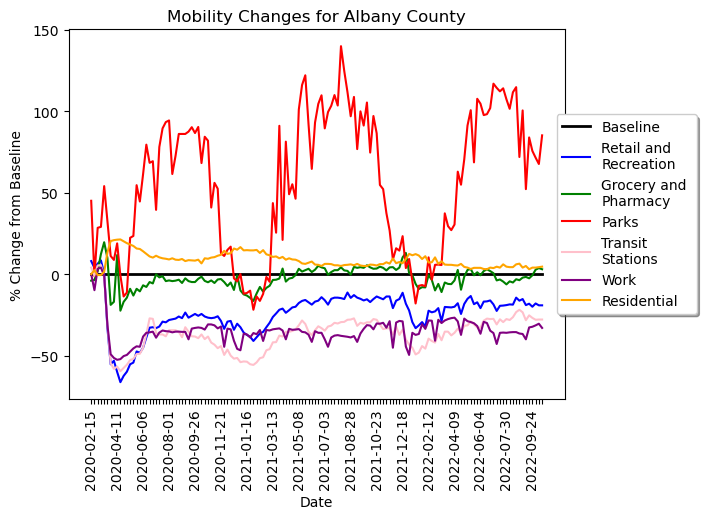

In [47]:
fig = plot_every_feature_for_county('Albany County')

In [48]:
def plot_every_county_for_feature(feature_index=3):
    """Returns a figure that represents a plot of every county's changes for a specified feature
        in the google mobility data. 

        3 = Retail and Recreation
        4 = Groceries and Pharmacies
        5 = Parks
        6 = Transit Stations
        7 = Work
        8 = Residential Areas
    Args:
        feature_index (str): index of the feature that is wanted. Mapping is described above.

    Returns:
        fig (matplotlib.figure.Figure): figure containing the resulting plot
    """
    feat_names = ['Retail and Recreation', 'Grocery and Pharmacy', 'Parks', 'Transit Stations', 'Work', 'Residential']
    feature = google_mobility_data_NY_cleaned.columns[feature_index]
    
    # Plot the baseline
    fig = plt.figure()
    plt.plot(google_mobility_data_NY_cleaned['date'], [0]*google_mobility_data_NY_cleaned.shape[0], label='Baseline', color='black', linewidth=2)
    
    # Plot each county
    for i, county in enumerate(google_mobility_data_NY_cleaned['county'].unique()):
        # Ensure all the dates are present for each county
        county_data = google_mobility_data_NY_cleaned[google_mobility_data_NY_cleaned['county'] == county]
            
        # Plot the results
        plt.plot(county_data['date'], county_data[feature], label=county)
        
    plt.xlabel('Date')
    plt.ylabel('% Change from Baseline')
    plt.title(f'New York {feat_names[feature_index - 3]} Mobility Changes ')
    #plt.legend(loc='best', ncol=5)
    plt.xticks(rotation=90)
    
    # Only keep every 8th tick
    for i, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
        if(i % 8 == 0):
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    return fig

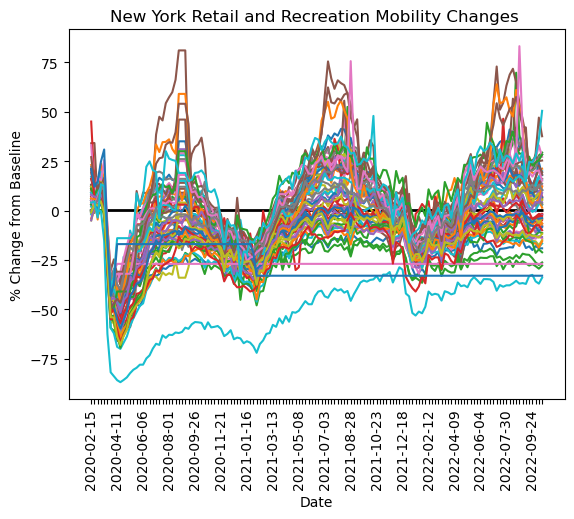

In [49]:
fig = plot_every_county_for_feature(feature_index=3)

## Weather Data

In [50]:
# Merge data and handle missing values
df_weather_target = pd.merge(left=df_weather, right=df_target, how='left', left_on=['county', 'datetime'], right_on=['County', 'Week Ending Date']).drop(labels=['County', 'Week Ending Date'], axis=1)
df_weather_target['Count'] = df_weather_target['Count'].fillna(0)
df_weather_target['Count'] = df_weather_target['Count'].astype('int')

In [51]:
# Convert datetime column to datetime type
df_weather_target['datetime'] = pd.to_datetime(df_weather_target['datetime'])

In [52]:
df_weather_target.head()

,county,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,Unnamed: 0,Season,FIPS,Count
0,BRONX,2020-01-11,46.000000,34.300000,40.357143,42.485714,26.328571,34.514286,25.842857,57.600000,...,66.142857,5.714286,3.428571,NaN,0.452857,Partially cloudy,NaN,NaN,NaN,0
1,BRONX,2020-01-18,46.571429,34.514286,40.657143,42.700000,26.428571,35.185714,28.300000,64.314286,...,69.942857,6.071429,3.000000,NaN,0.650000,Partially cloudy,NaN,NaN,NaN,0
2,BRONX,2020-01-25,41.414286,28.842857,35.000000,37.128571,20.042857,28.757143,19.857143,56.185714,...,96.414286,8.357143,4.000000,NaN,0.812857,Clear,NaN,NaN,NaN,0
3,BRONX,2020-02-01,41.471429,34.300000,37.728571,37.257143,27.014286,31.742857,25.700000,62.728571,...,71.928571,6.242857,3.142857,NaN,0.102857,Partially cloudy,NaN,NaN,NaN,0
4,BRONX,2020-02-08,49.171429,35.728571,41.142857,46.857143,28.342857,35.971429,30.900000,69.014286,...,56.314286,4.885714,2.714286,NaN,0.400000,Partially cloudy,NaN,NaN,NaN,0


In [53]:
# Remove redundant index column
df_weather_target = df_weather_target.drop(columns=['Unnamed: 0', 'Season', 'FIPS'])

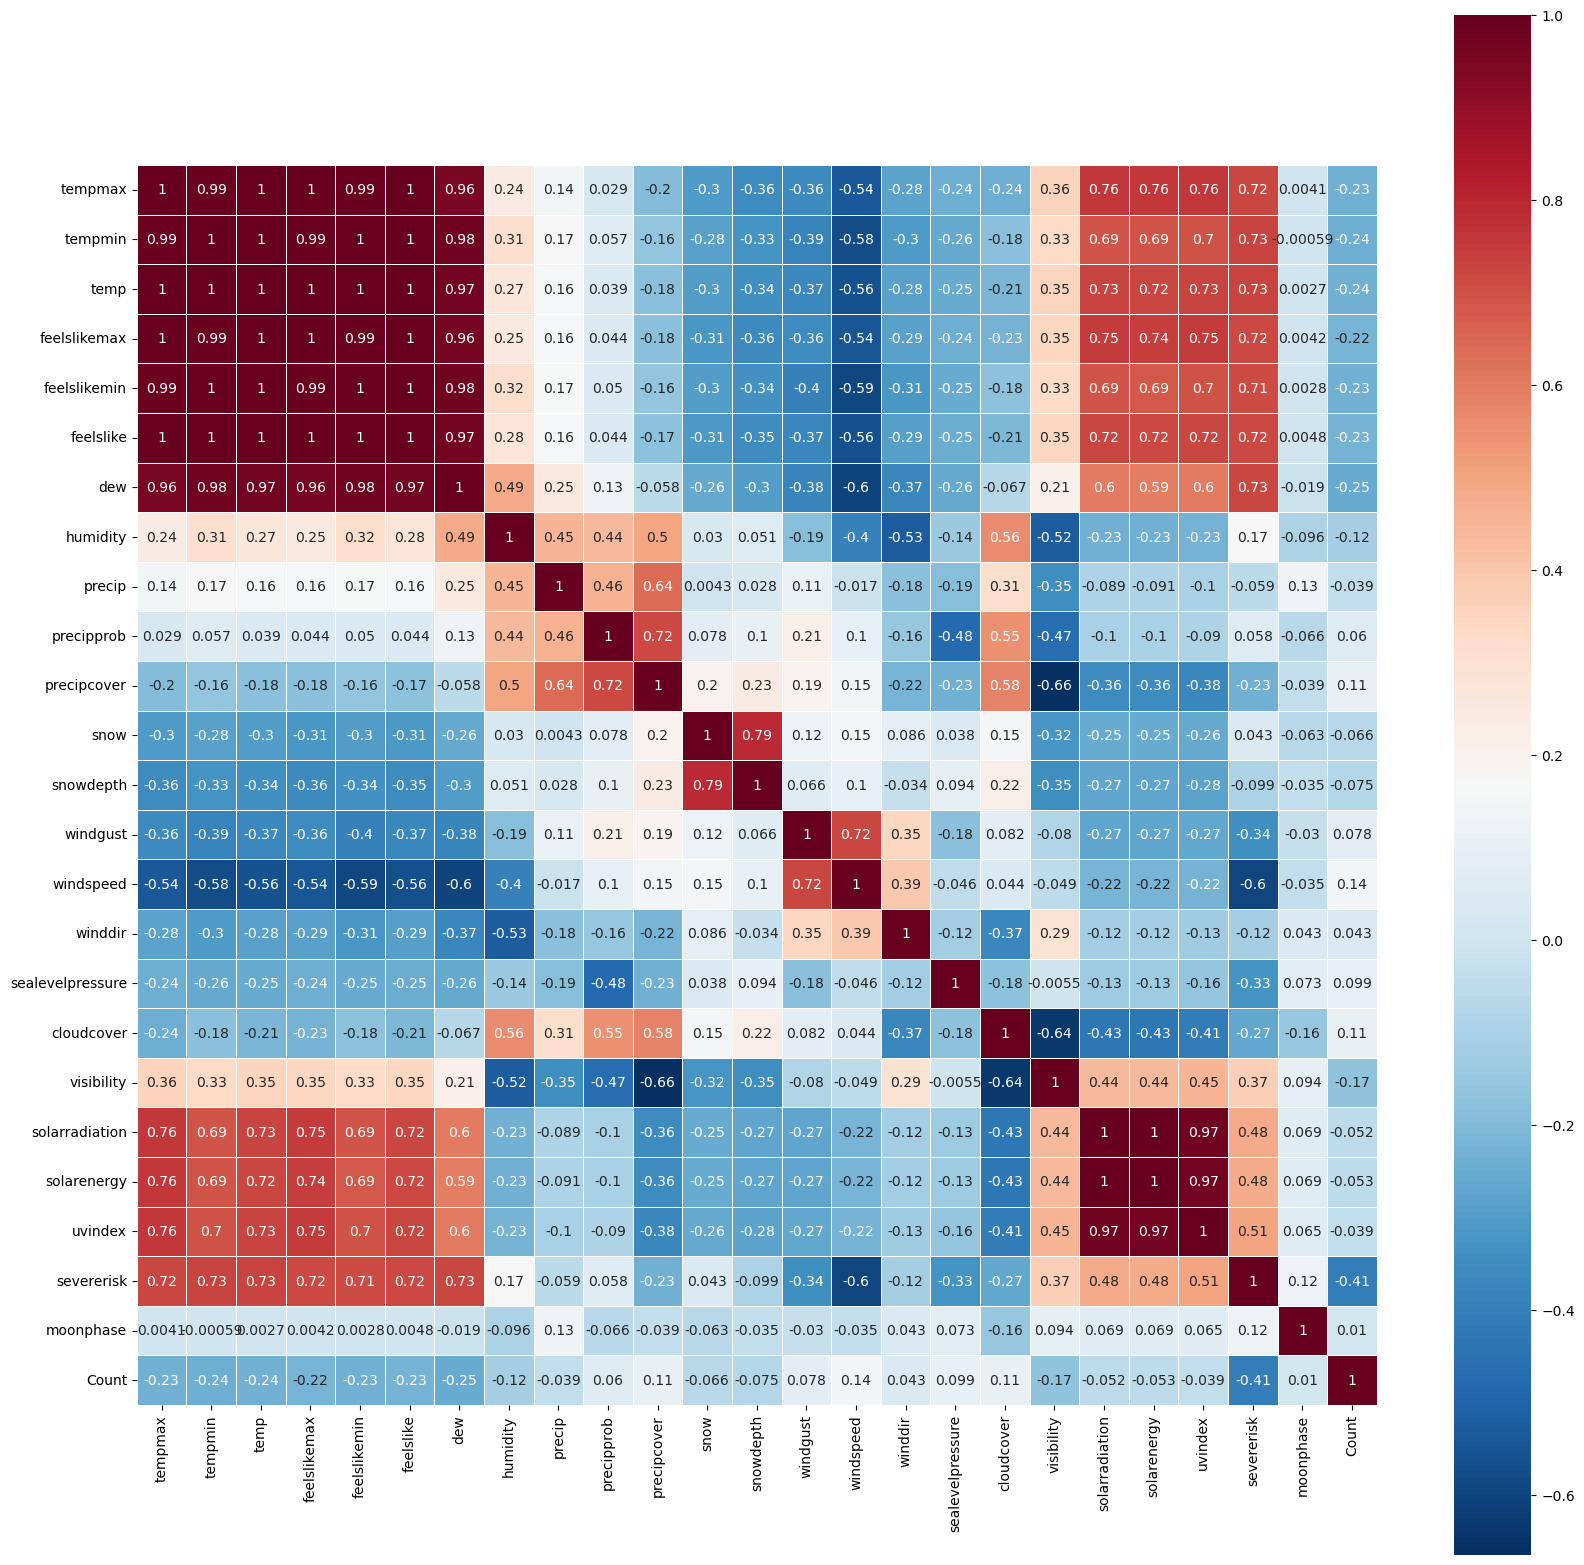

In [54]:
# Plot Pearson Correlation matrix heatmap to visualize correlation between weather features and case count
plt.figure(figsize=(20,20))
corr_matrix = df_weather_target[df_weather_target['county'] == 'BRONX'].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', linewidth=0.5, square=True)
plt.show()

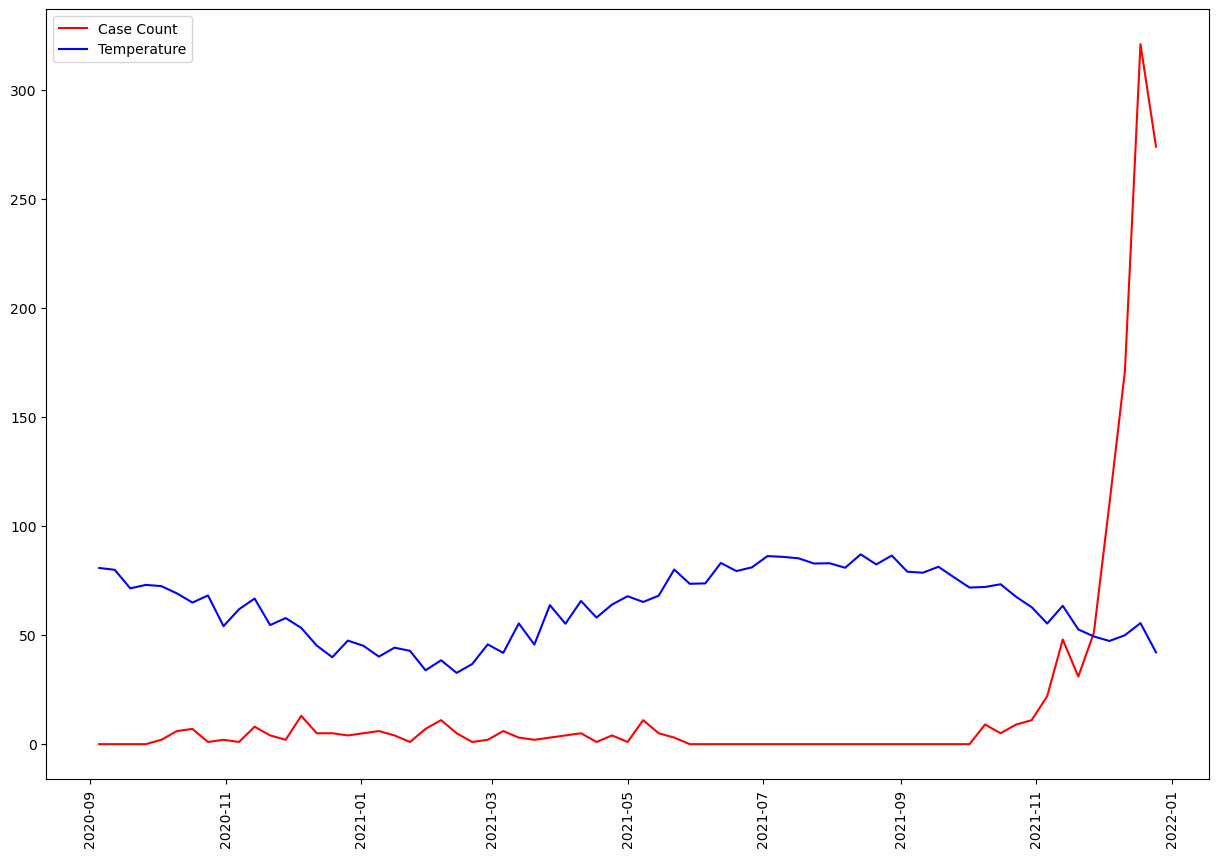

In [55]:
# Plot line chart to visualize trend and relationship between temperature and case count
df_weather_target_bronx = df_weather_target[(df_weather_target['county'] == 'BRONX') & ((df_weather_target['datetime'] >= '2020-09-01') & (df_weather_target['datetime'] <= '2021-12-31'))]
plt.figure(figsize=(15,10))
plt.plot(df_weather_target_bronx['datetime'], df_weather_target_bronx['Count'], color='red', label='Case Count')
plt.plot(df_weather_target_bronx['datetime'], df_weather_target_bronx['tempmax'], color='blue', label='Temperature')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [56]:
# Identify NA values in features
X = df_weather_target.drop(labels=['Count', 'county', 'conditions', 'datetime', 'preciptype'], axis=1)
X.isna().any()

tempmax             False
tempmin             False
temp                False
feelslikemax        False
feelslikemin        False
feelslike           False
dew                 False
humidity            False
precip              False
precipprob          False
precipcover         False
snow                False
snowdepth           False
windgust             True
windspeed           False
winddir             False
sealevelpressure     True
cloudcover          False
visibility          False
solarradiation      False
solarenergy         False
uvindex             False
severerisk           True
moonphase           False
dtype: bool

,Feature,F-Score
7,humidity,212.428336
14,windspeed,148.051779
11,snow,131.522403
6,dew,121.554152
13,windgust,83.752922
0,tempmax,76.839966
3,feelslikemax,73.483924
22,severerisk,72.449473
5,feelslike,64.182689
2,temp,62.648583


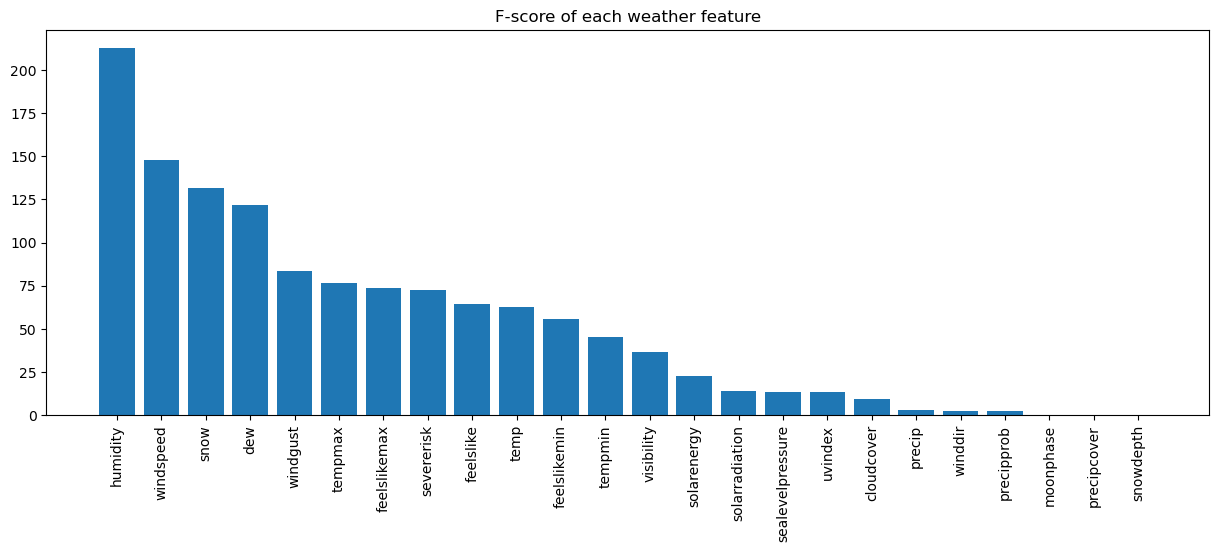

In [57]:
# Fill NA values because SelectKBest cannot tolerate NA
X = df_weather_target.drop(labels=['Count', 'county', 'conditions', 'datetime', 'preciptype'], axis=1)
X = X.fillna(value={'windgust': X['windgust'].mean(), 'sealevelpressure': X['sealevelpressure'].mean(), 'severerisk': X['severerisk'].mean()})
y = df_weather_target['Count']
# Perform univariate feature selection analysis
ftest = SelectKBest(score_func=f_regression, k='all')
ftest.fit(X, y)
f_scores = pd.DataFrame(ftest.scores_)
dfcolumns = pd.DataFrame(X.columns)
f_scores = pd.concat([dfcolumns, f_scores], axis=1)
f_scores.columns = ['Feature', 'F-Score']  
f_scores = f_scores.sort_values(by='F-Score', ascending=False)
display(f_scores)
# Plot scores to visualize most important weather features in relation to case count determined by SelectKBest F-regression
plt.figure(figsize=(15,5))
plt.bar(x=f_scores['Feature'], height=f_scores['F-Score'])
plt.xticks(rotation=90)
plt.title('F-score of each weather feature')
plt.show()

In [58]:
# Show the 1/2 most important weather features identified by SelectKBest F-regression
f_scores.iloc[:int(f_scores.shape[0]/2)]['Feature']

7         humidity
14       windspeed
11            snow
6              dew
13        windgust
0          tempmax
3     feelslikemax
22      severerisk
5        feelslike
2             temp
4     feelslikemin
1          tempmin
Name: Feature, dtype: object

## Population Data

In [59]:
# Rename a couple columns for convenience in the population data
pop_df.rename(columns={"CTYNAME": "County"},inplace=True)
pop_df['County']=pop_df['County'].replace("ST. LAWRENCE","ST LAWRENCE")

# Merge the population data with the Influenza (target) data
df_work=df_target.merge(pop_df,how='left',on=['County'])

In [60]:
# Calculate the total number of cases
total_cases = df_work.groupby('County')['Count'].sum()
county=total_cases.index
cases=total_cases.values

# Create a dataframe containing county-level demographics
corr=pd.DataFrame(county.values,columns=['County'])
corr['Cases']=cases

# Group the data by age bucjet and clean it
pop_est=df_work.groupby('County')['POPESTIMATE'].nth(-1)
corr['pop_est']=pop_est[county].values
pop_04=df_work.groupby('County')['0to4'].nth(-1)
corr['pop_04']=pop_04[county].values
pop_517=df_work.groupby('County')['5to17'].nth(-1)
corr['pop_517']=pop_517[county].values
pop_1849=df_work.groupby('County')['18to49'].nth(-1)
corr['pop_1849']=pop_1849[county].values
pop_5064=df_work.groupby('County')['50to64'].nth(-1)
corr['pop_5064']=pop_5064[county].values
pop_65plus=df_work.groupby('County')['65plus'].nth(-1)
corr['pop_65plus']=pop_65plus[county].values
print(corr.head())


        County  Cases  pop_est  pop_04  pop_517  pop_1849  pop_5064  \
0       ALBANY   7108   305506   15204    40561    137409     59060   
1     ALLEGANY   2000    46091    2424     6850     18531      9231   
2        BRONX  54480  1418207  100199   248464    629330    251448   
3       BROOME  10008   190488    9886    26919     78164     38539   
4  CATTARAUGUS   2256    76117    4160    12476     27937     16522   

   pop_65plus  
0       53272  
1        9055  
2      188766  
3       36980  
4       15022  


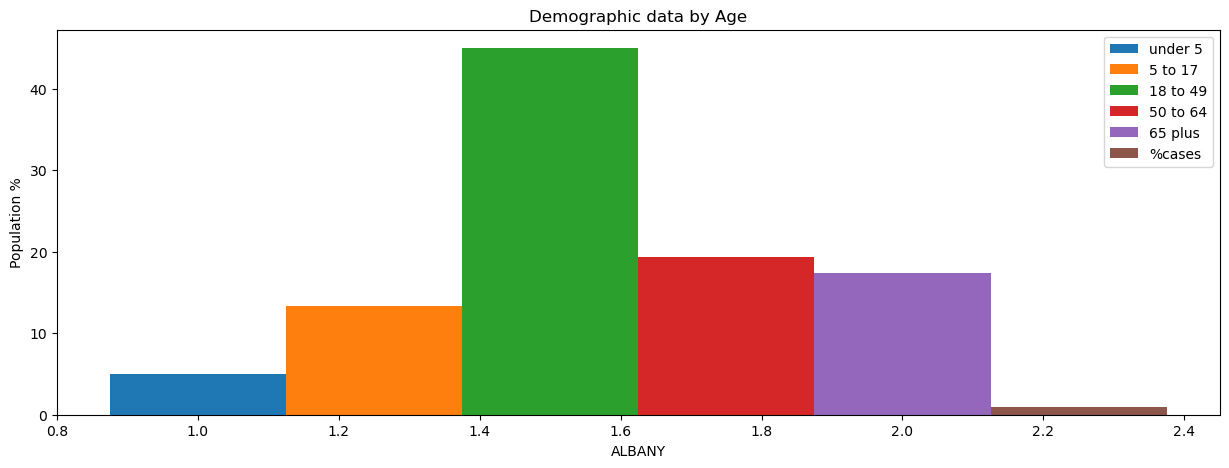

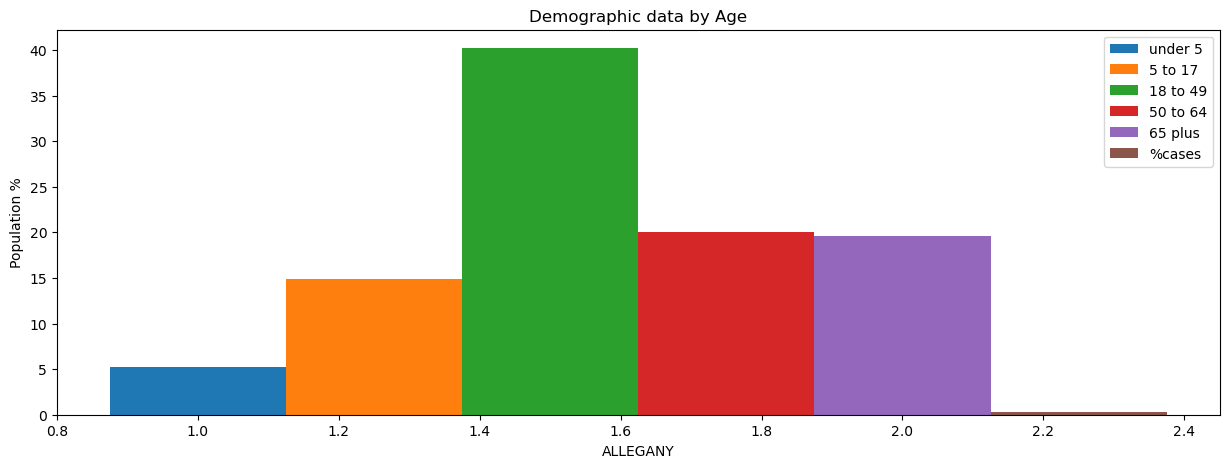

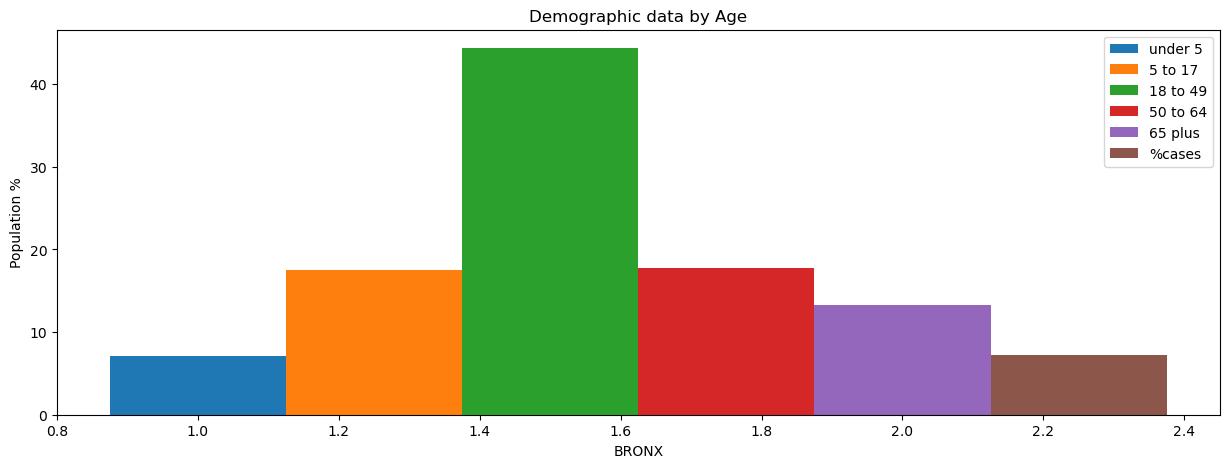

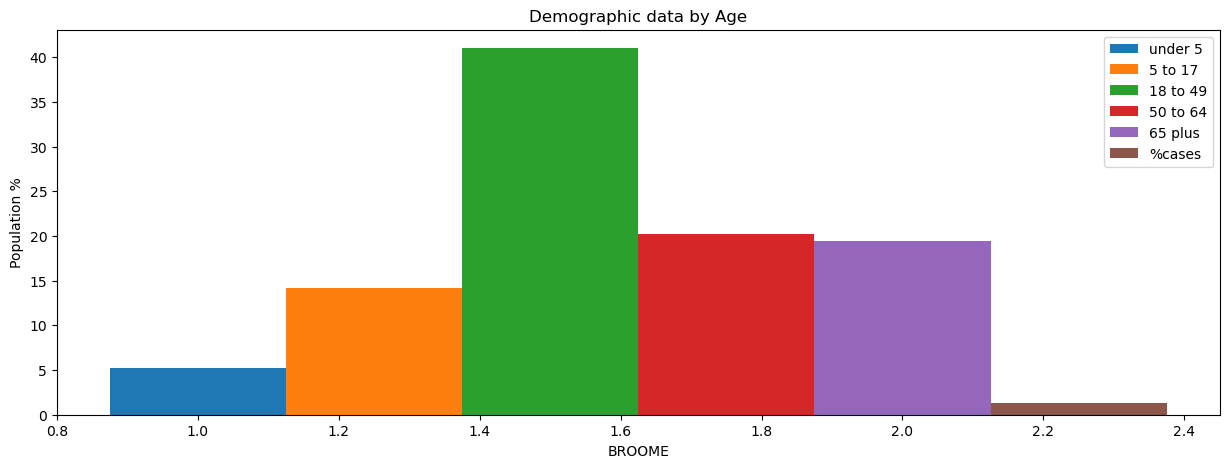

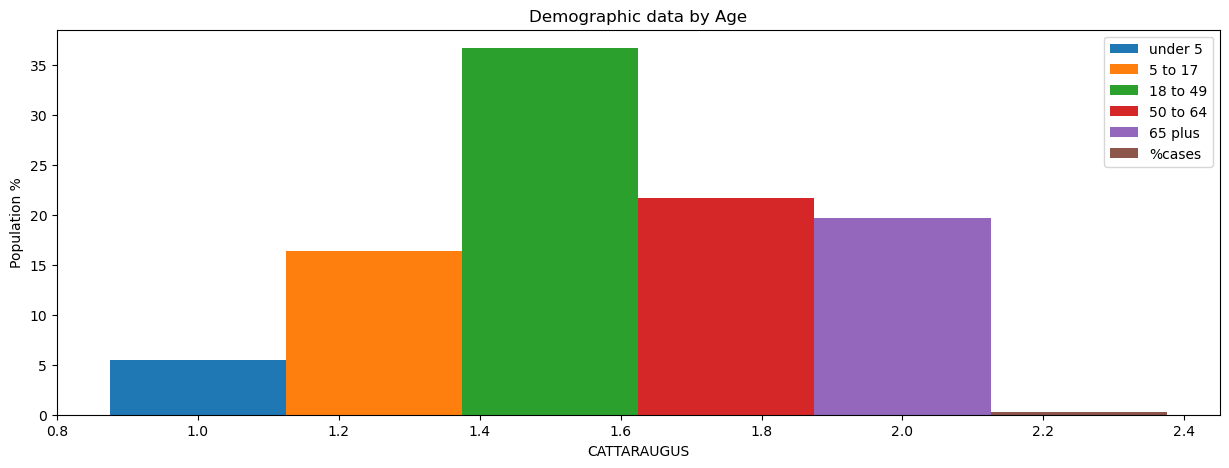

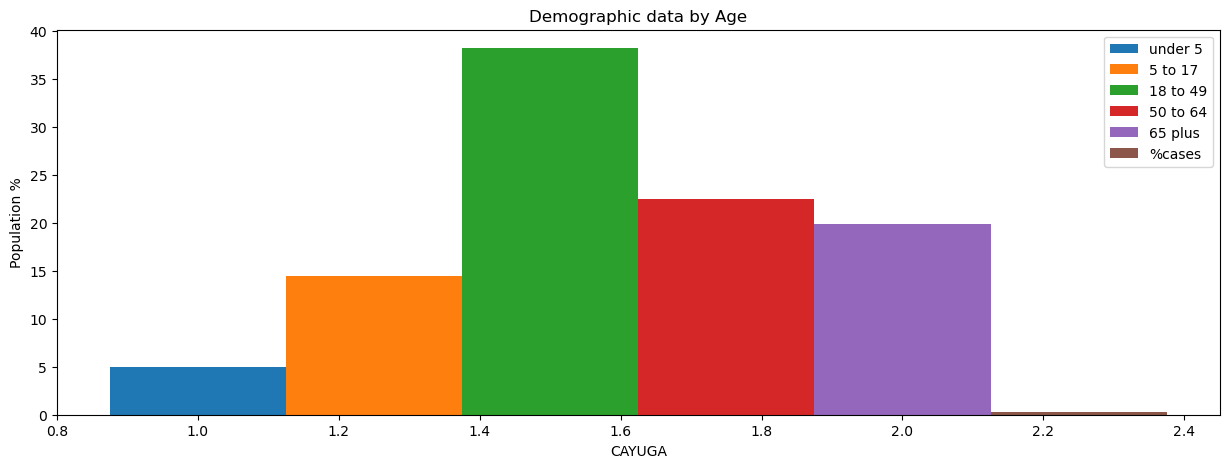

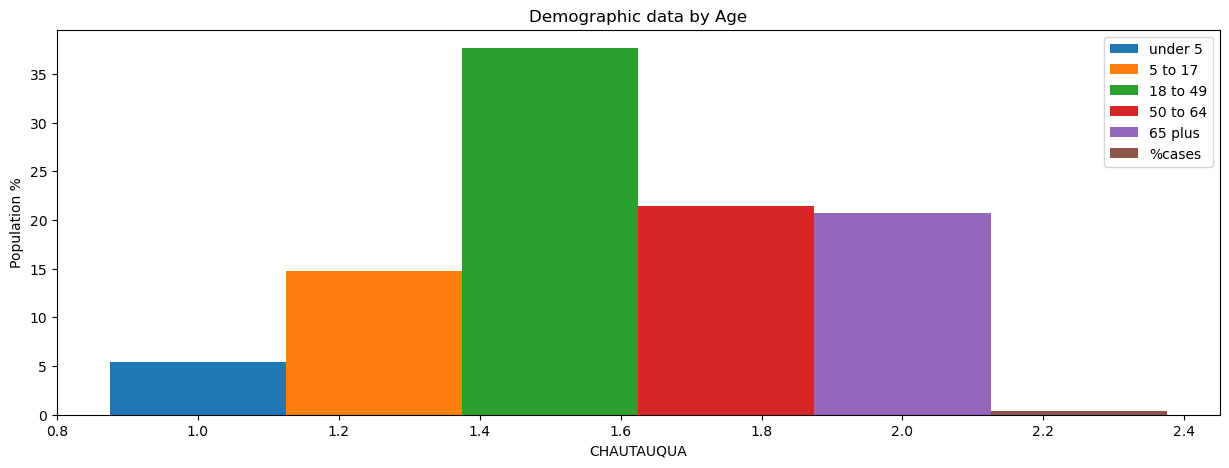

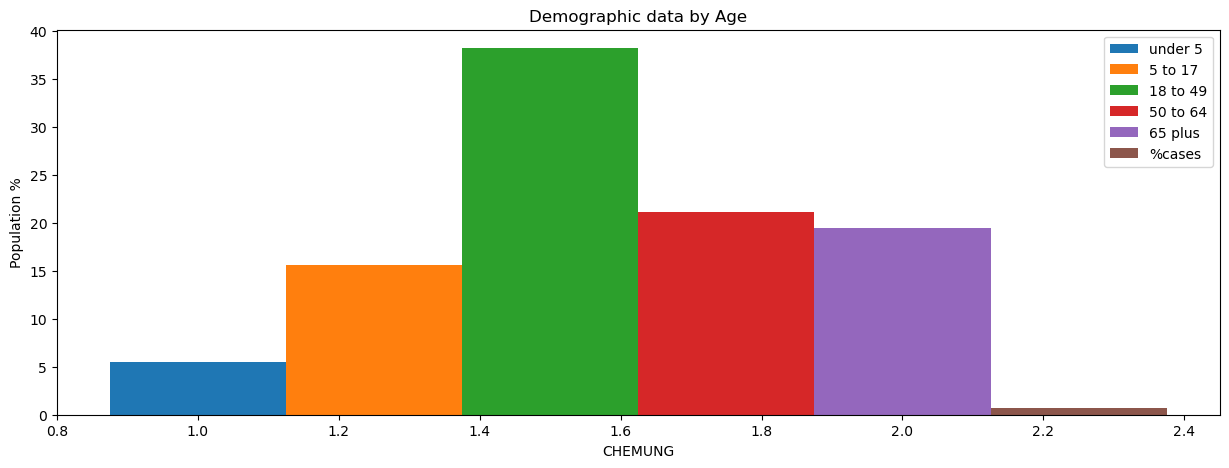

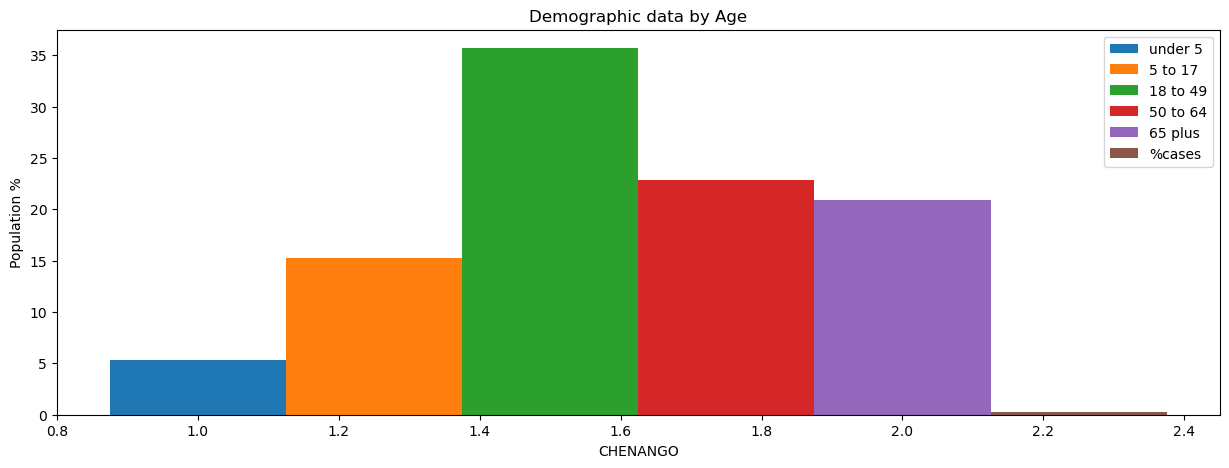

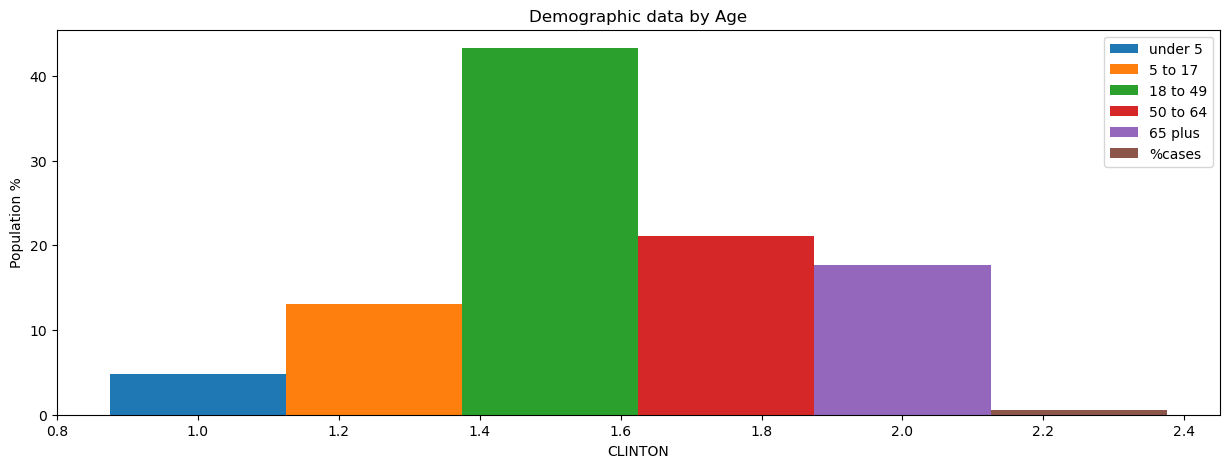

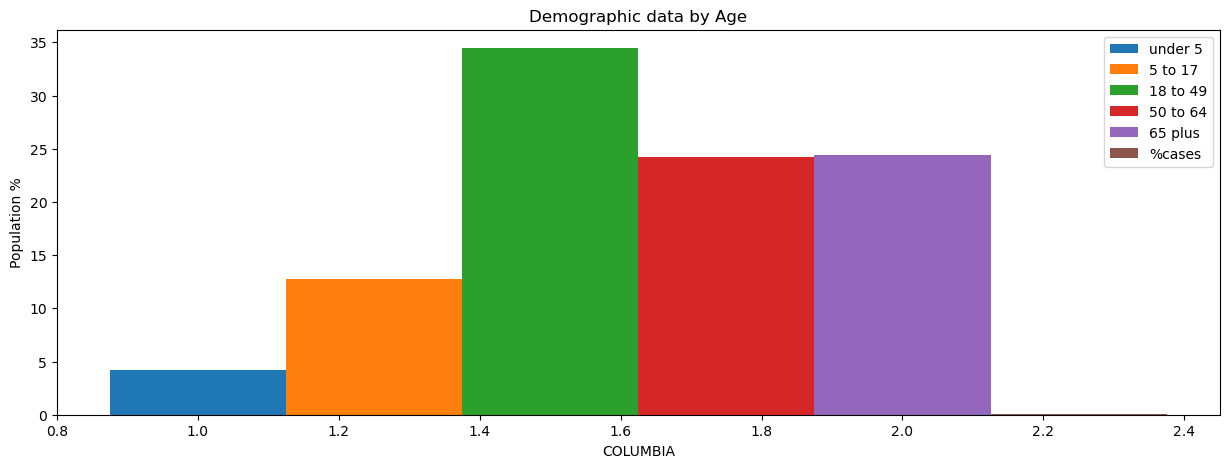

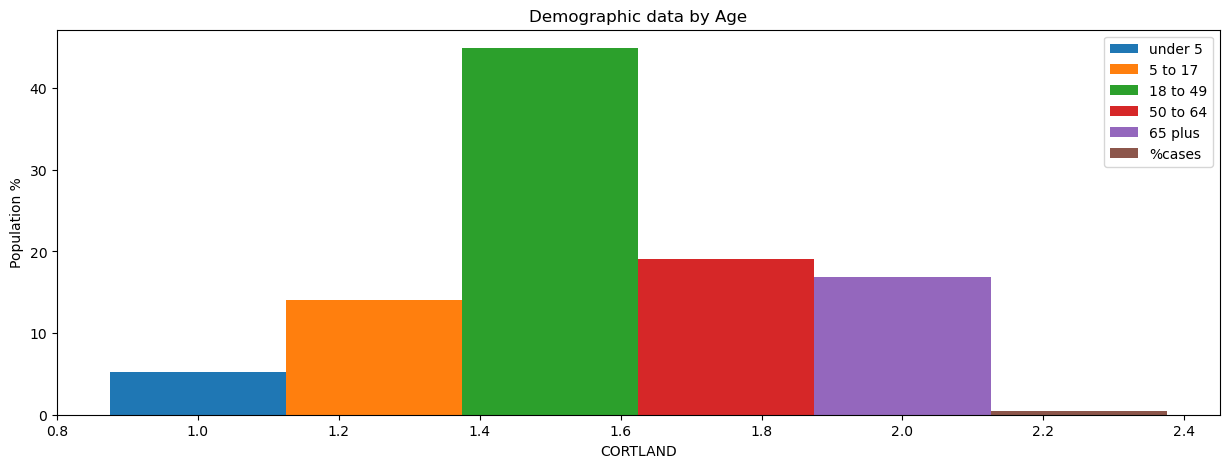

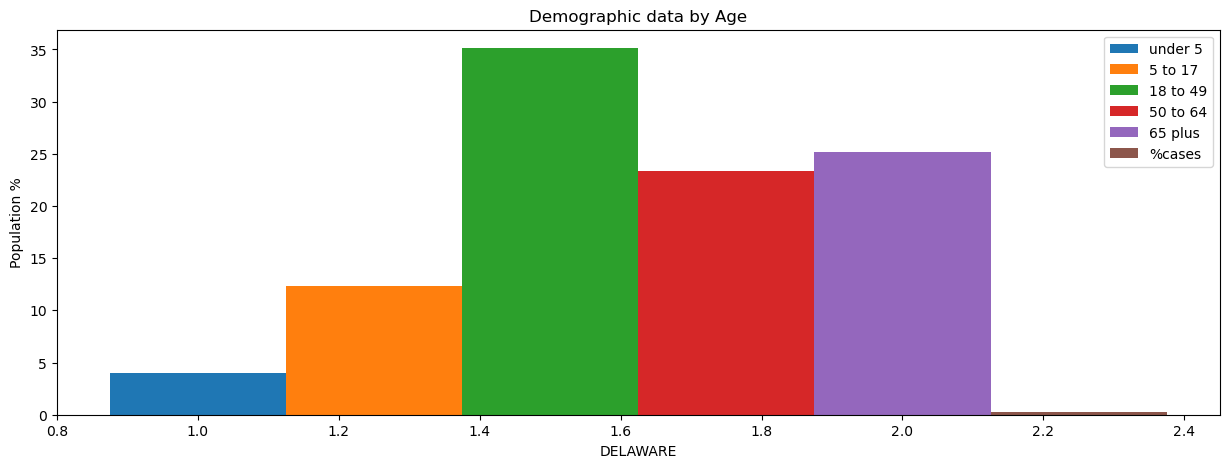

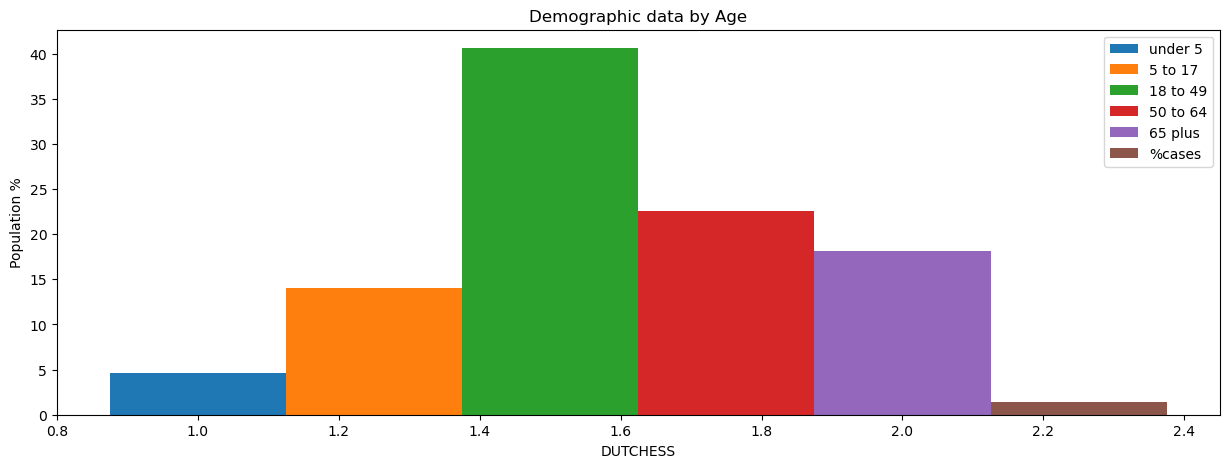

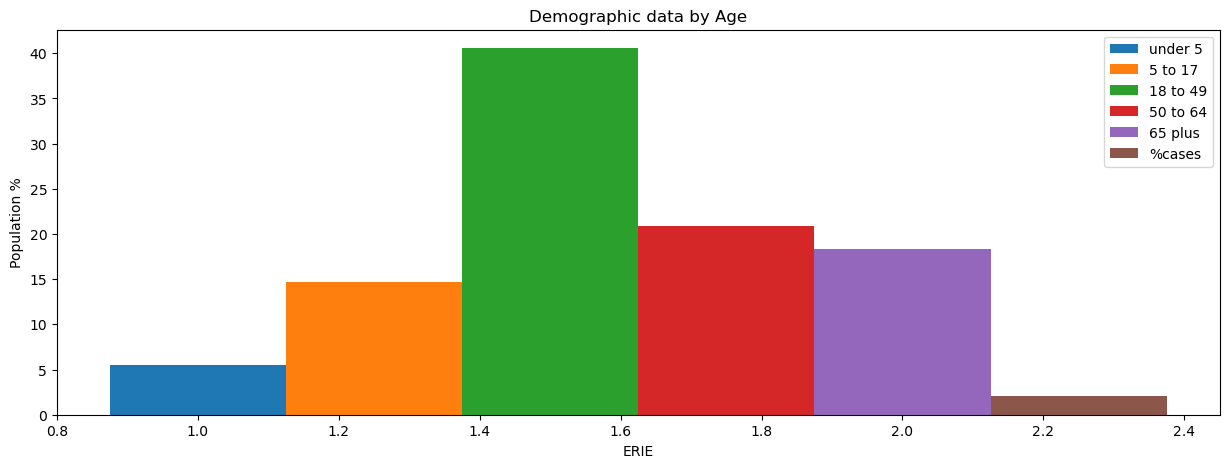

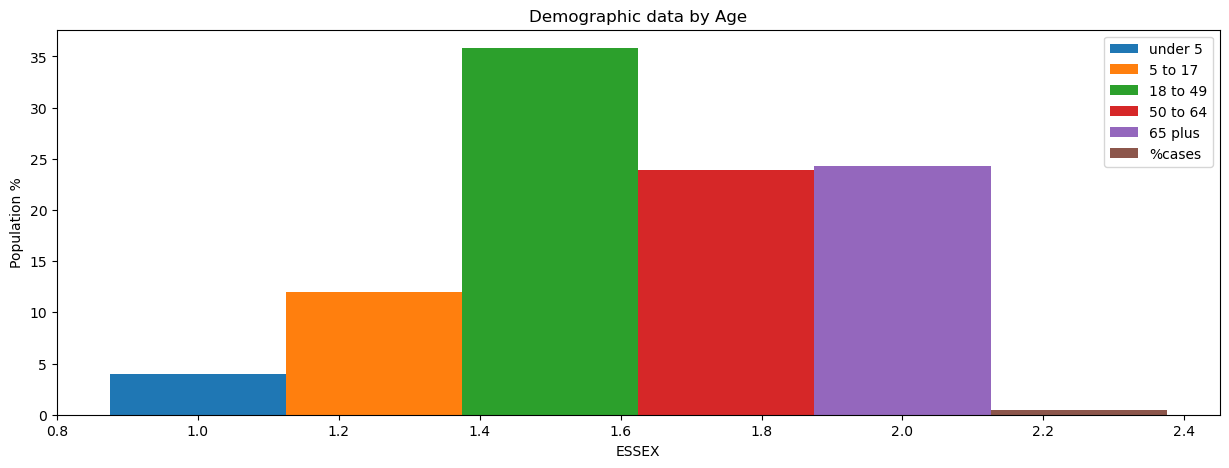

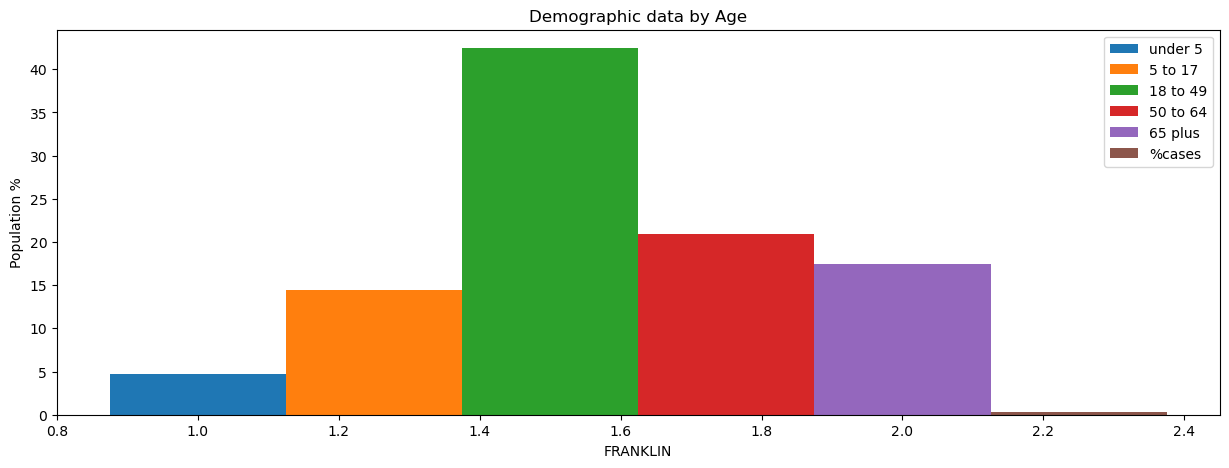

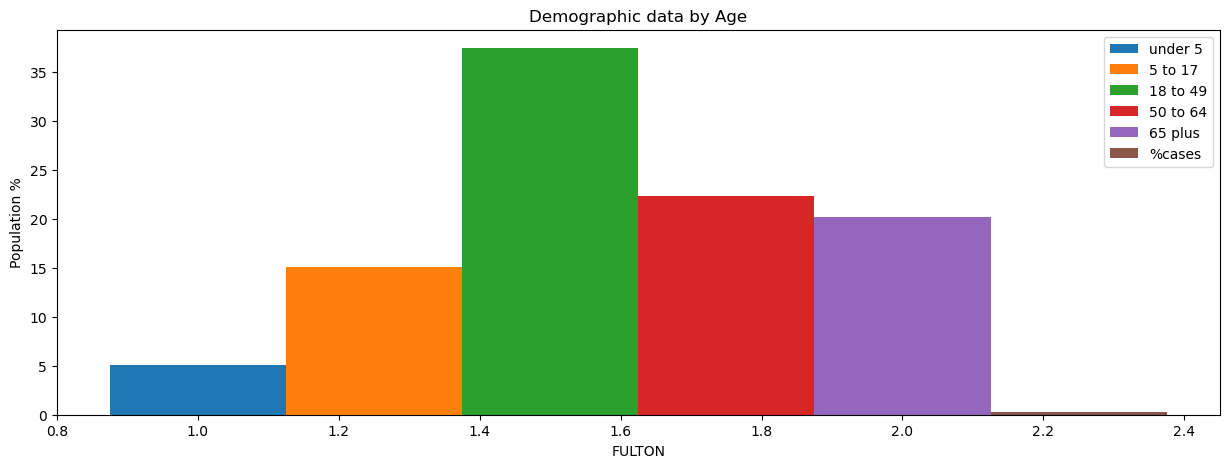

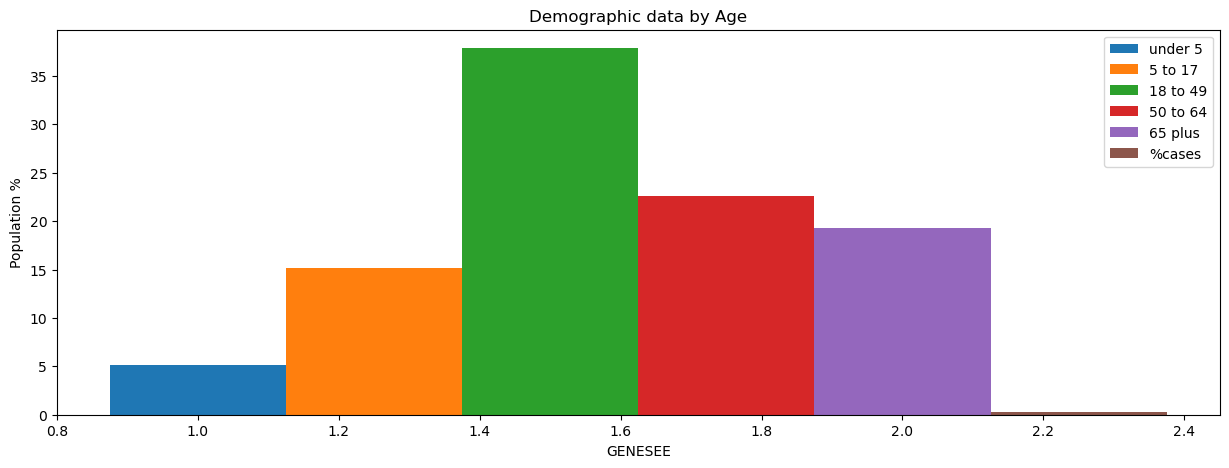

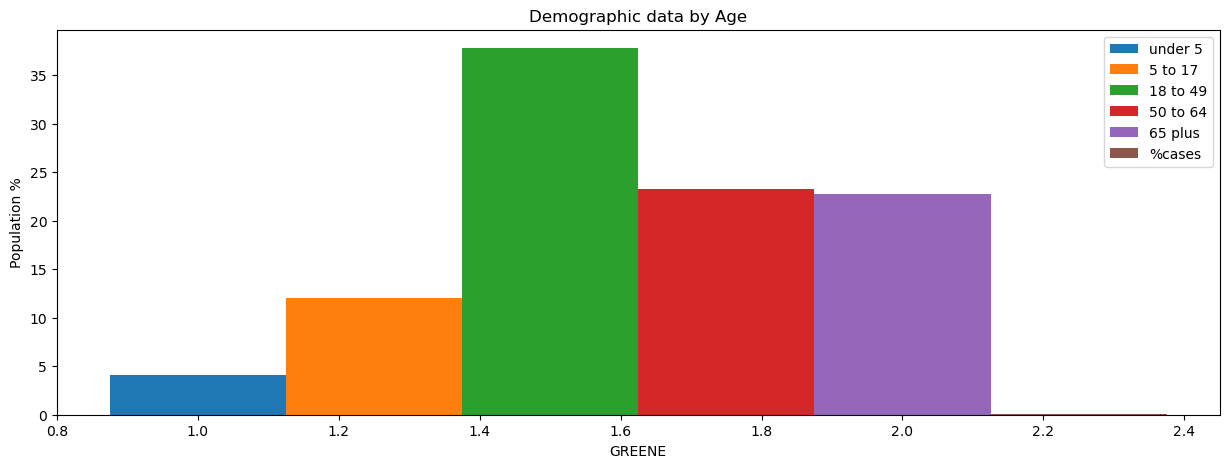

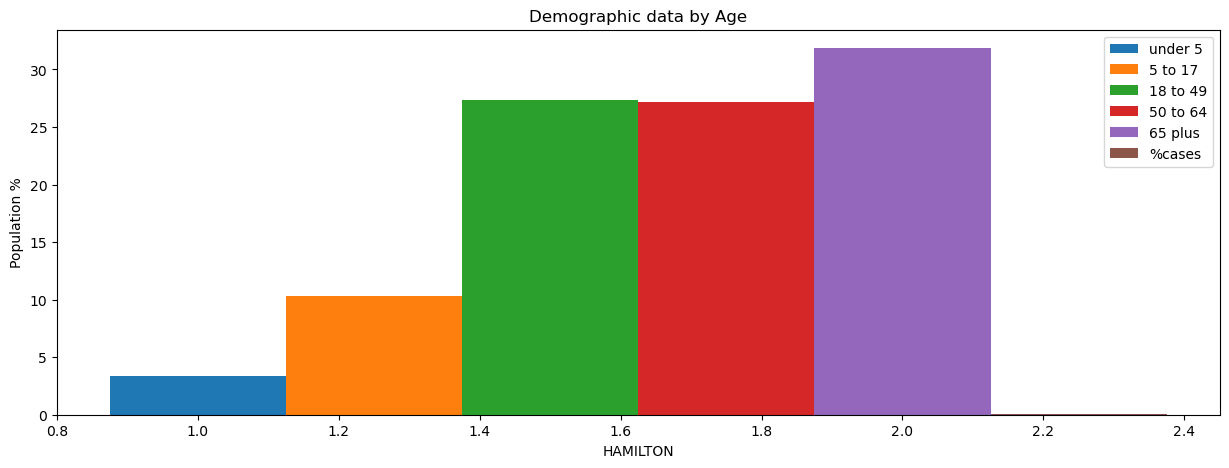

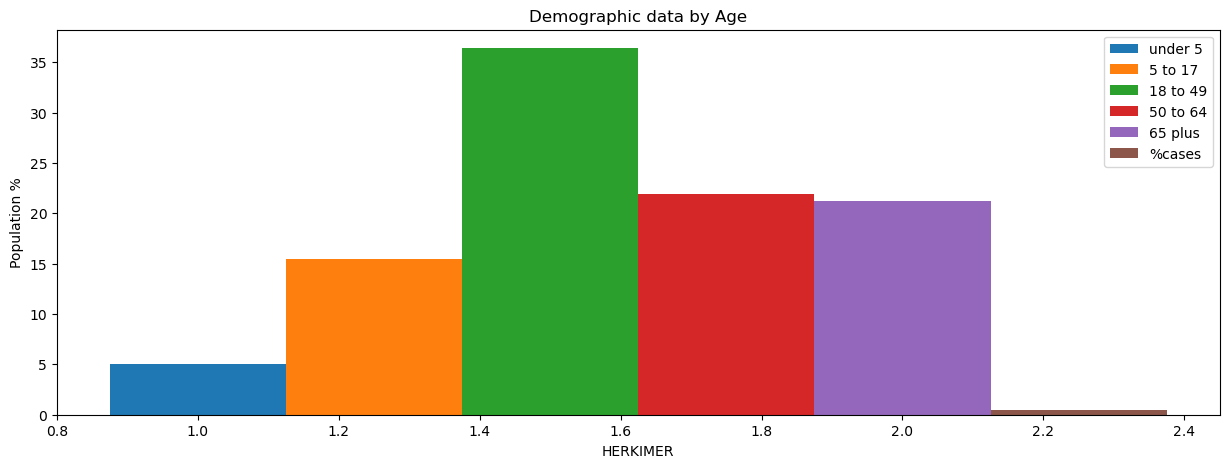

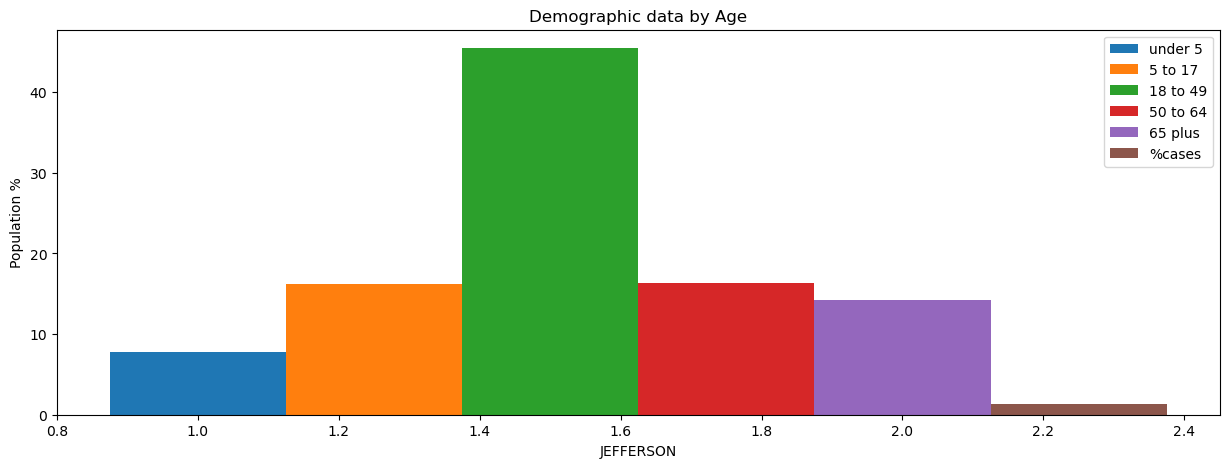

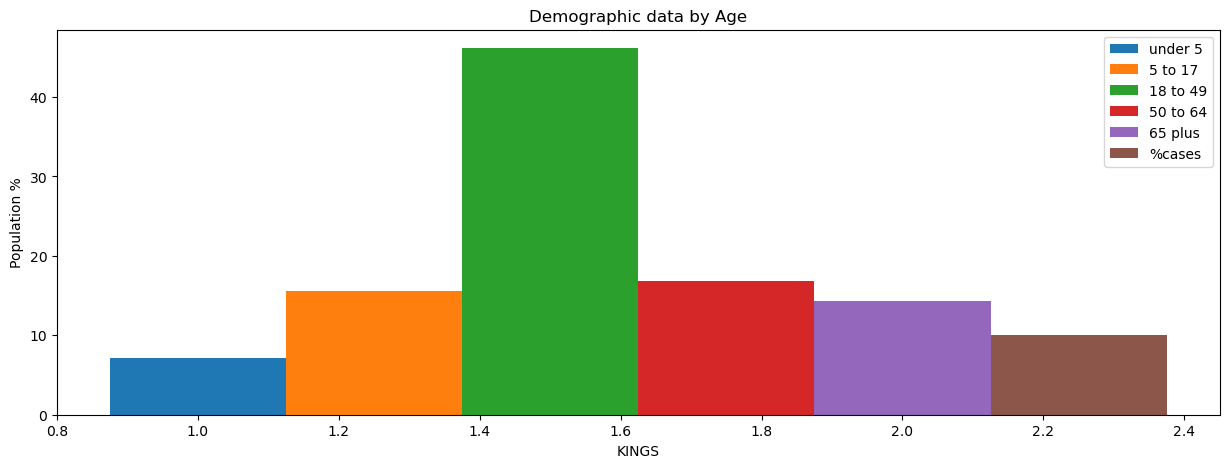

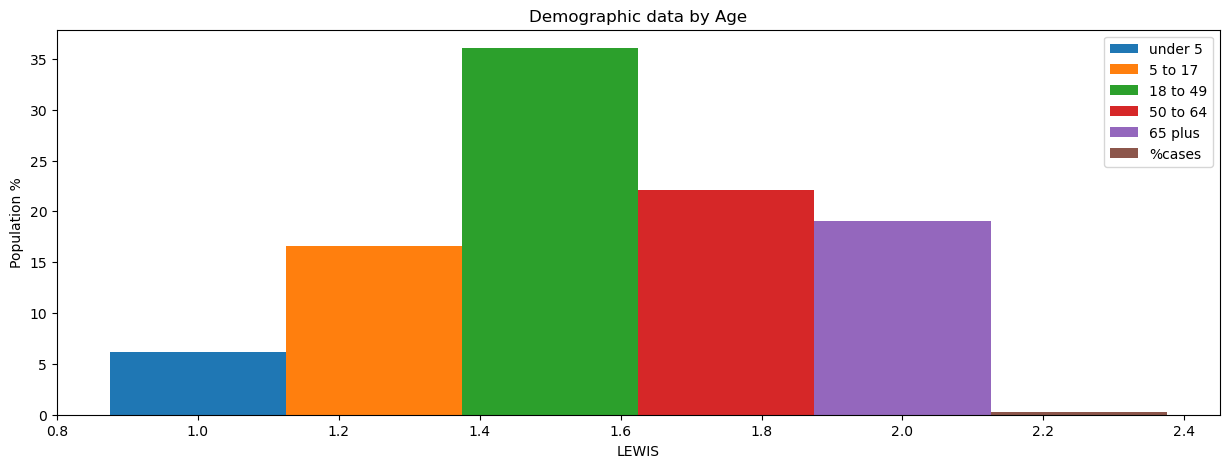

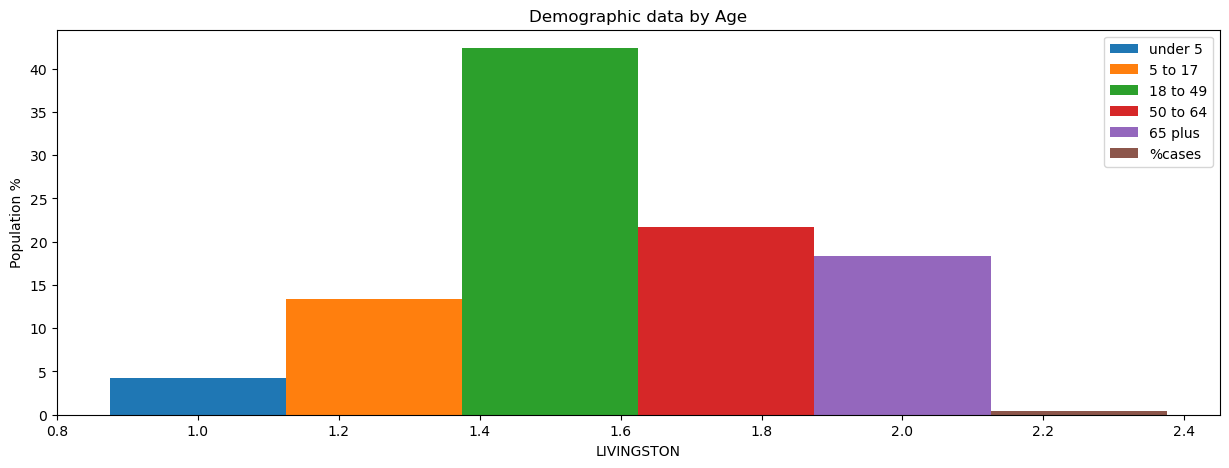

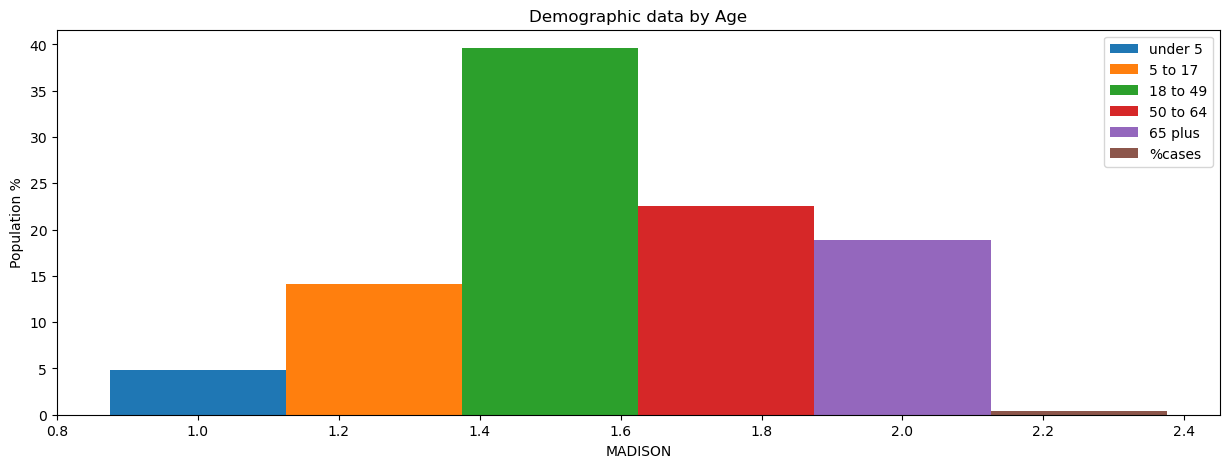

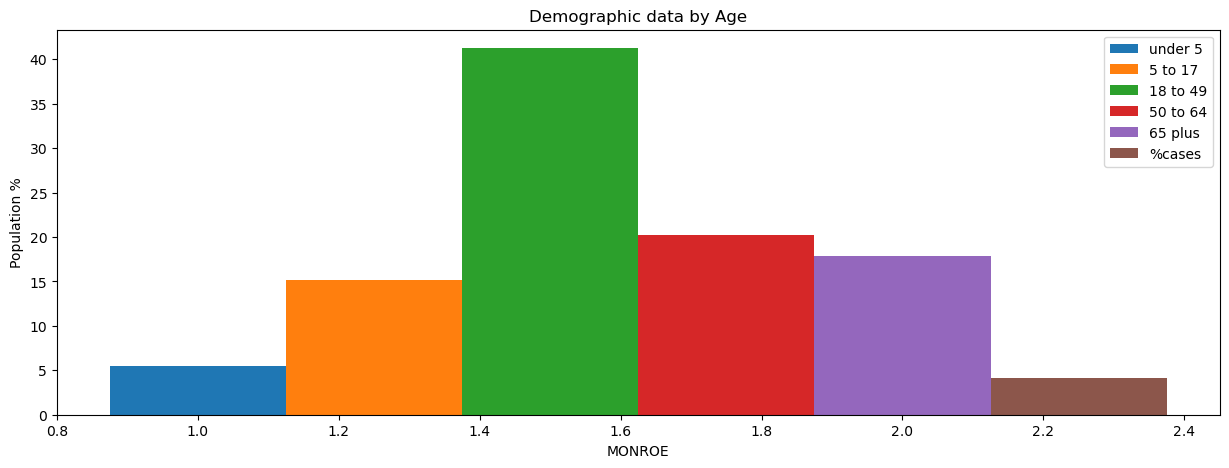

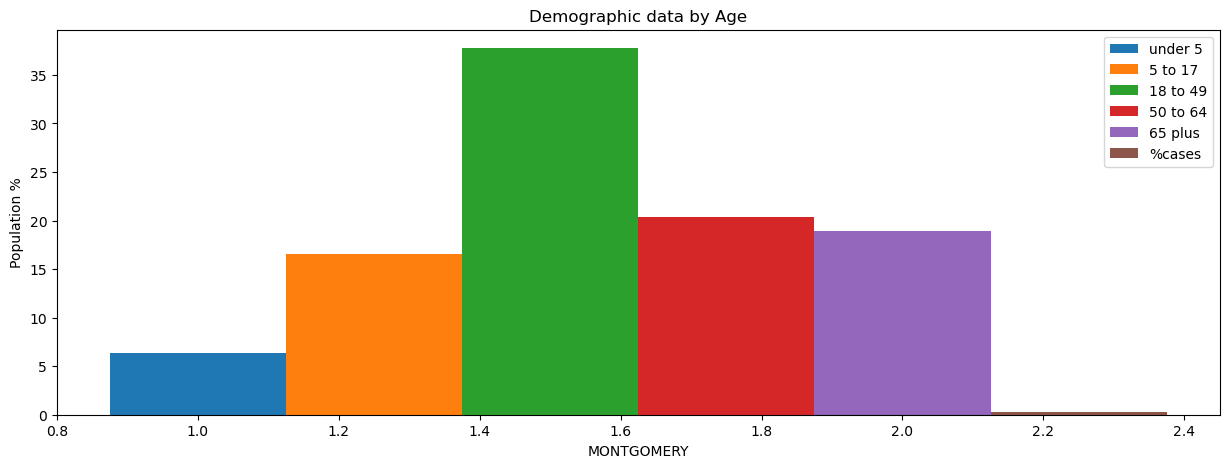

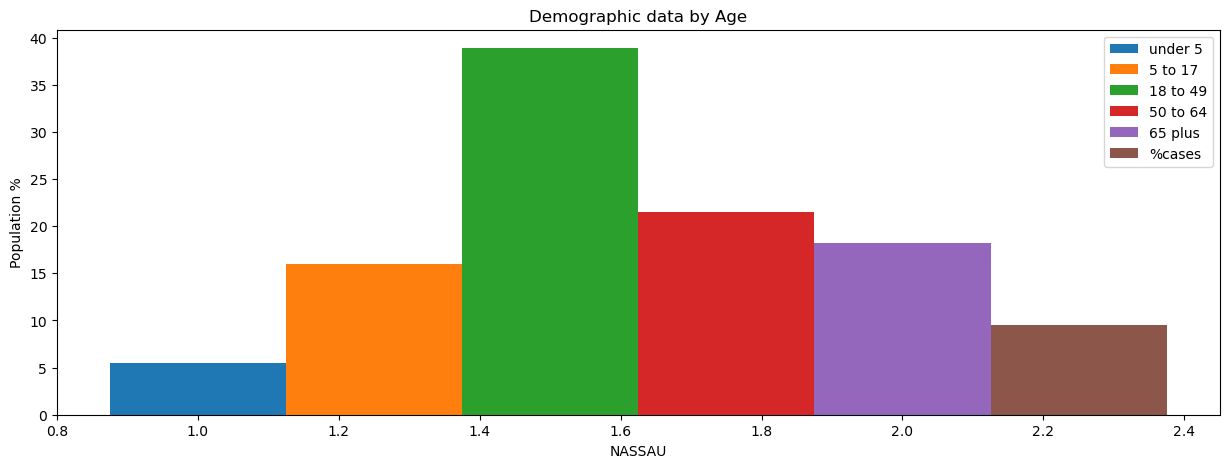

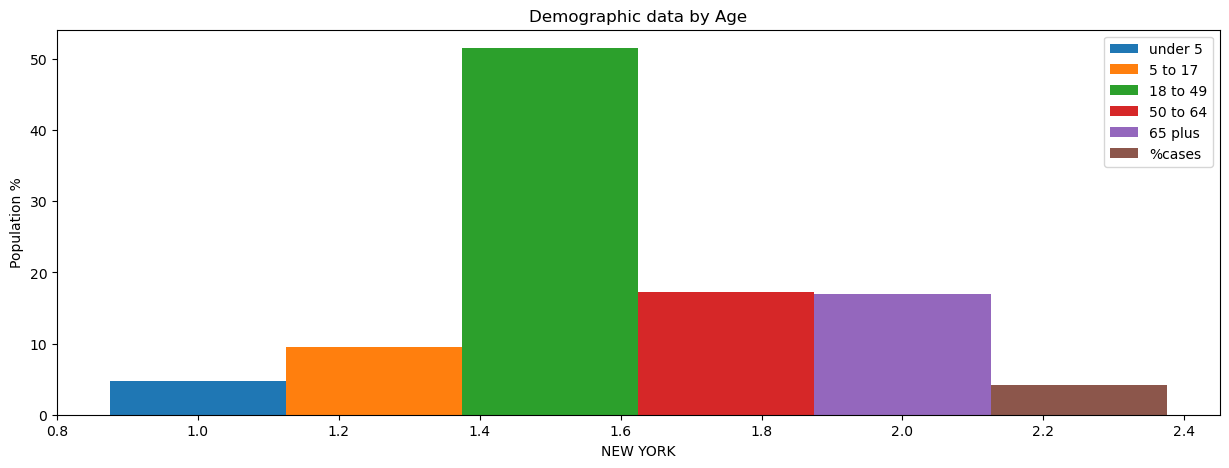

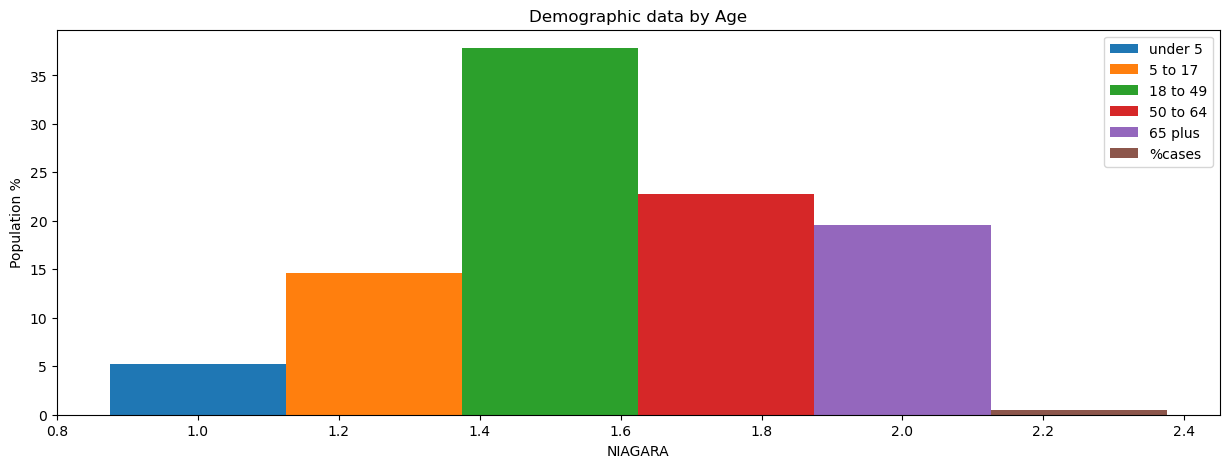

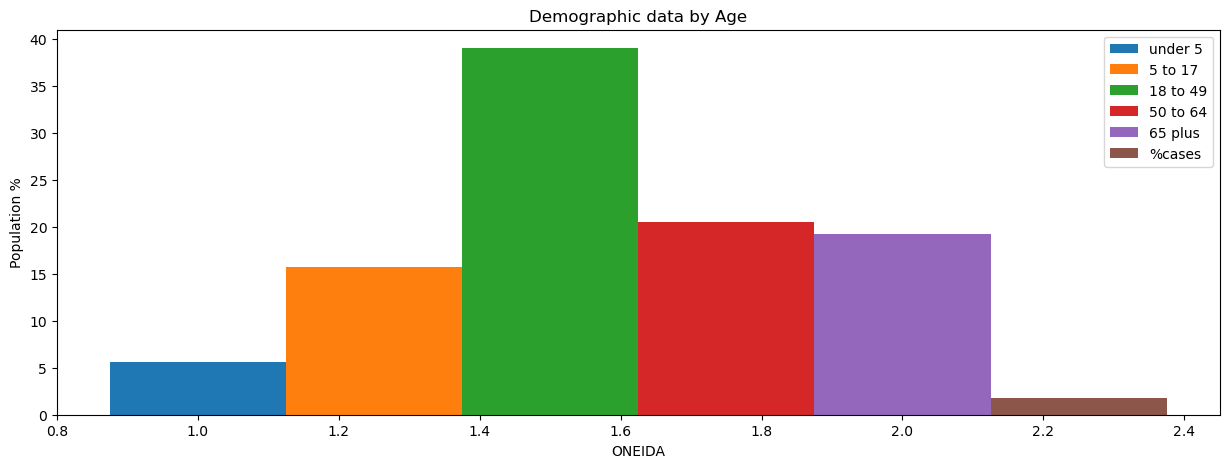

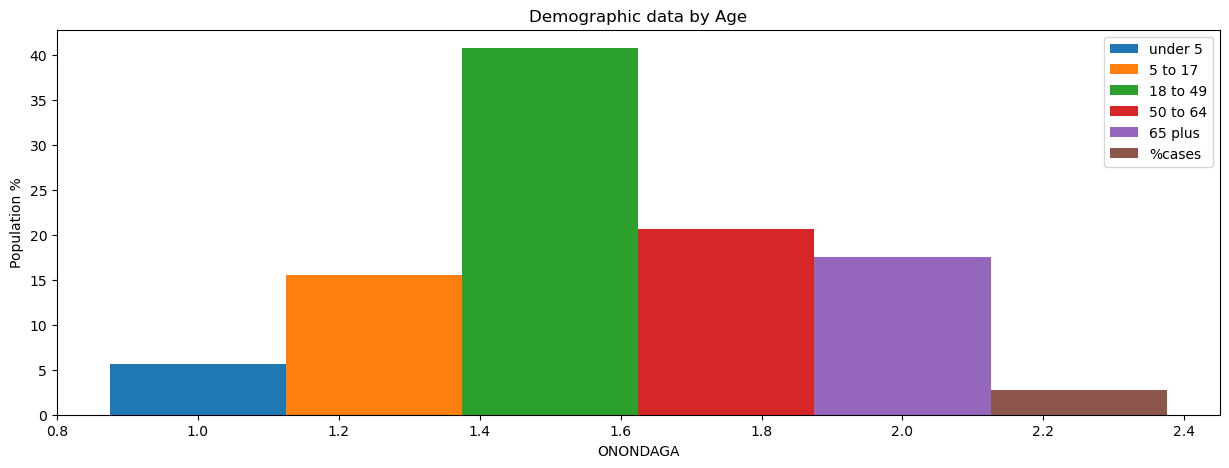

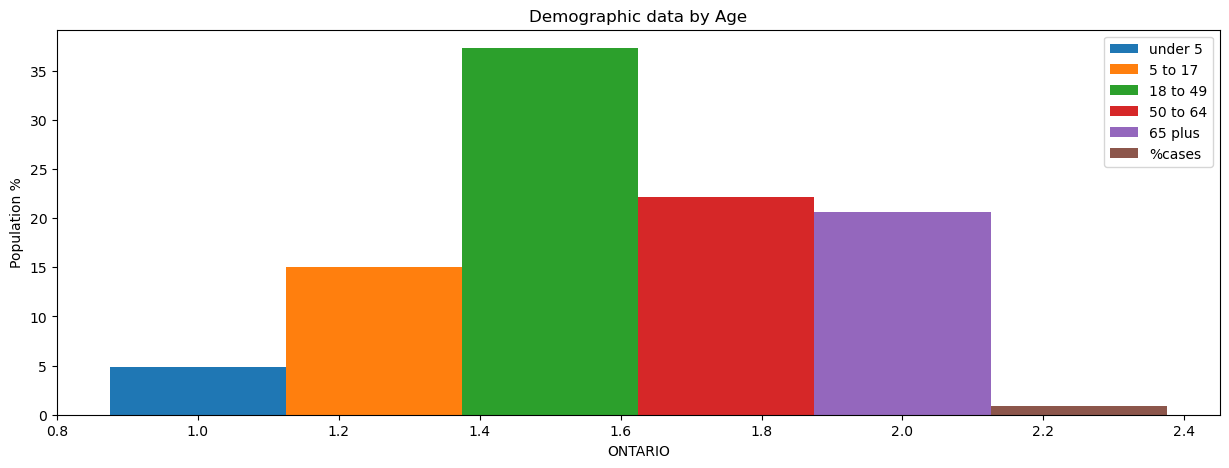

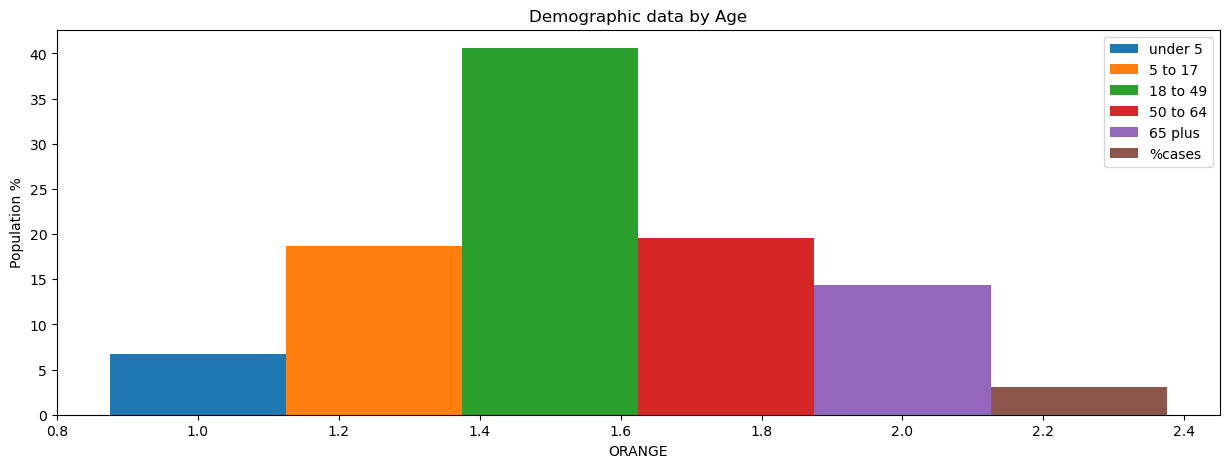

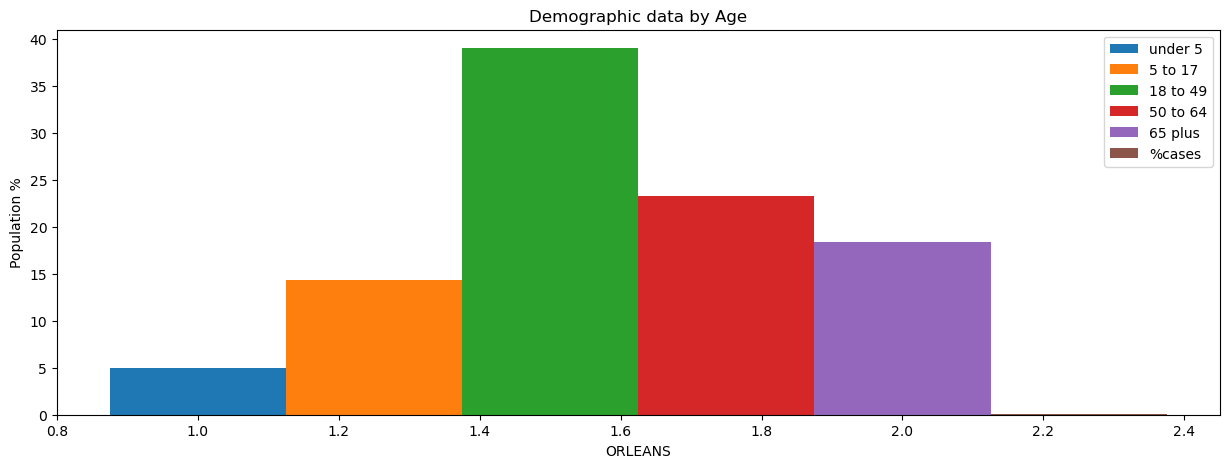

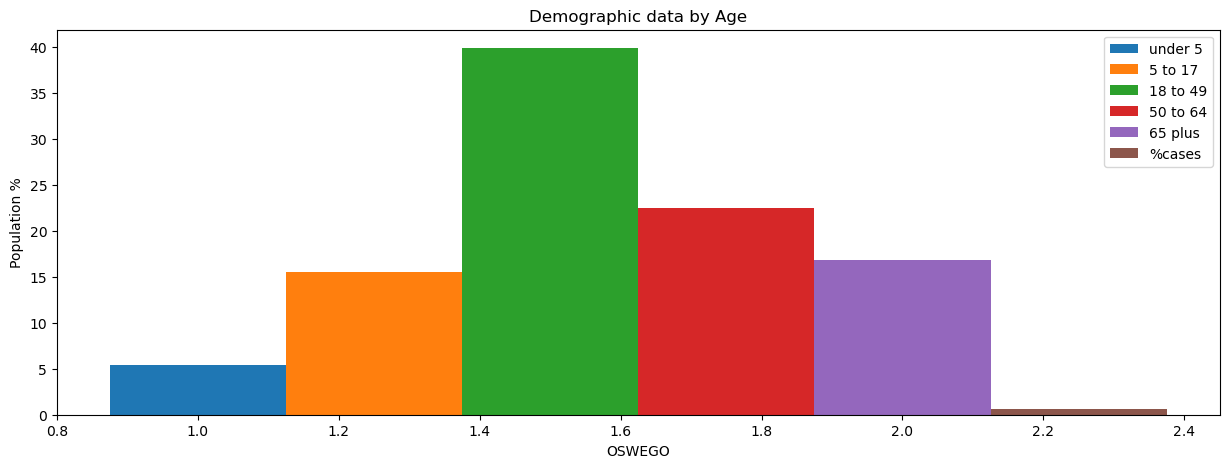

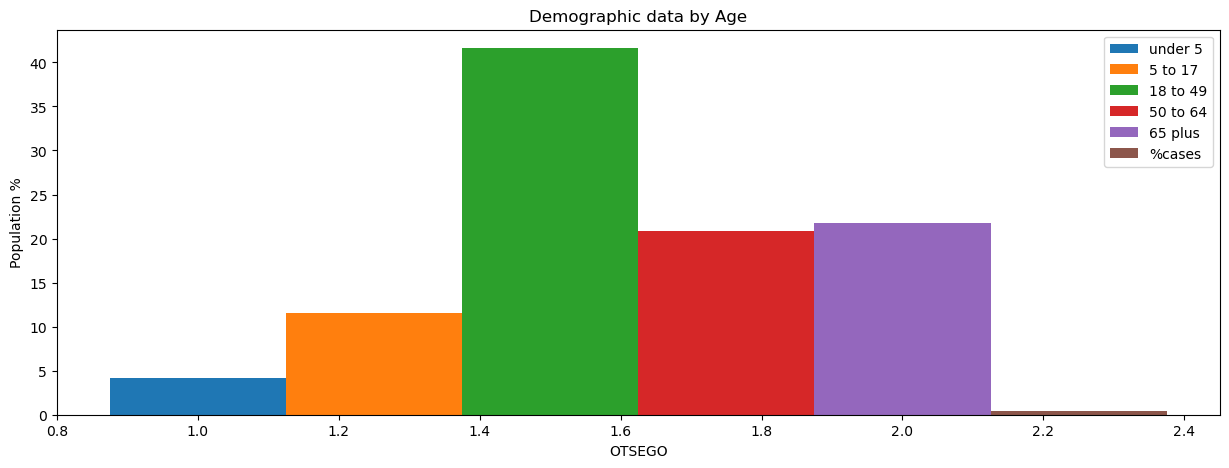

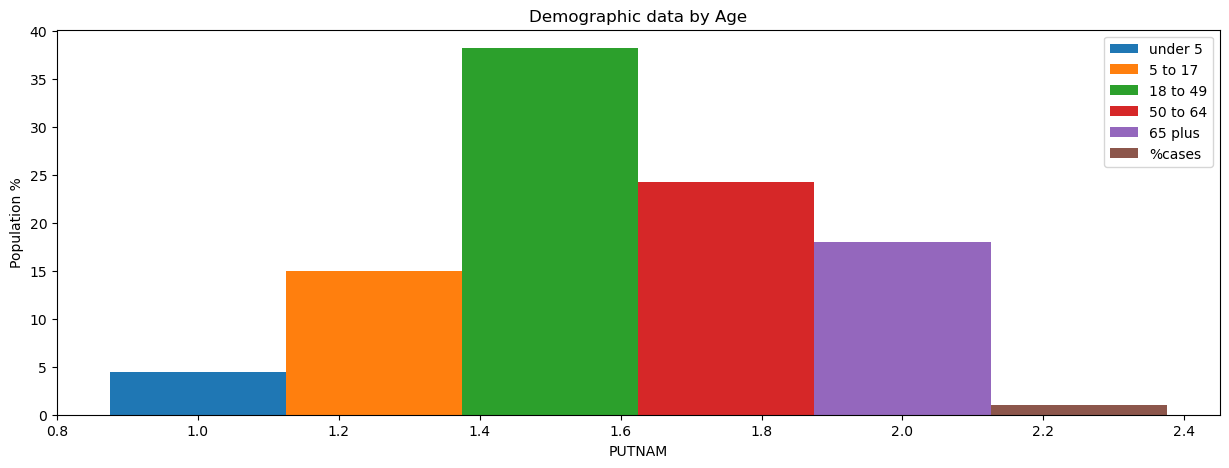

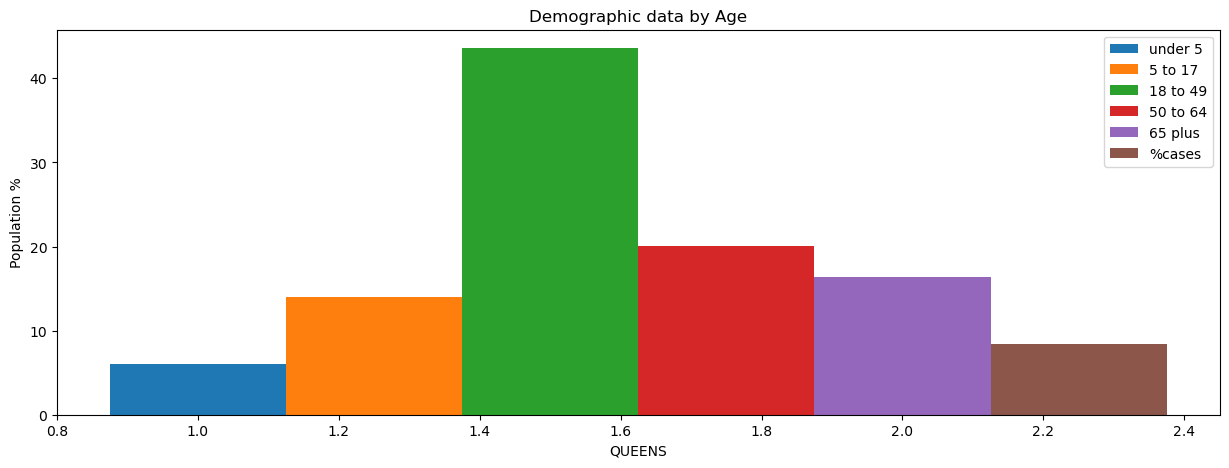

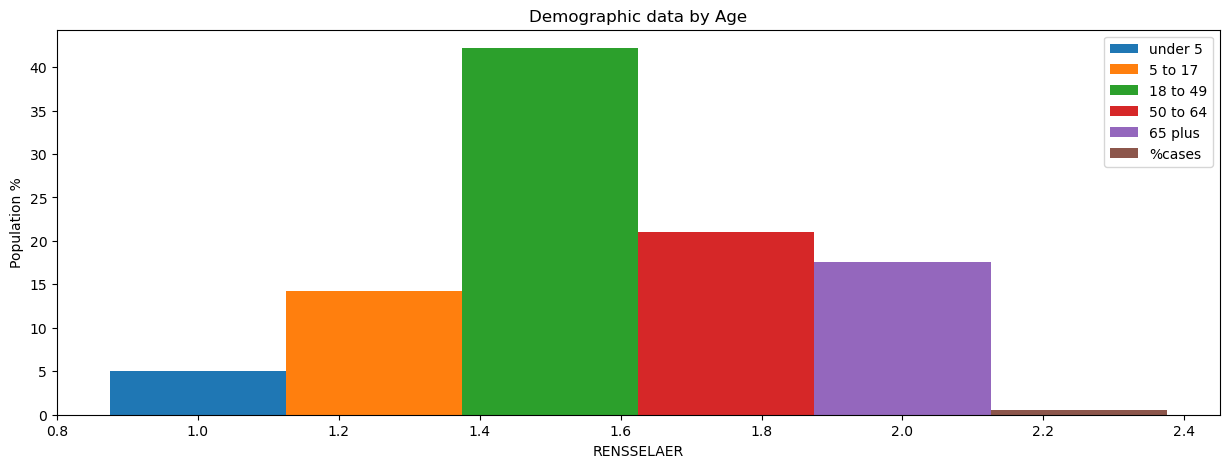

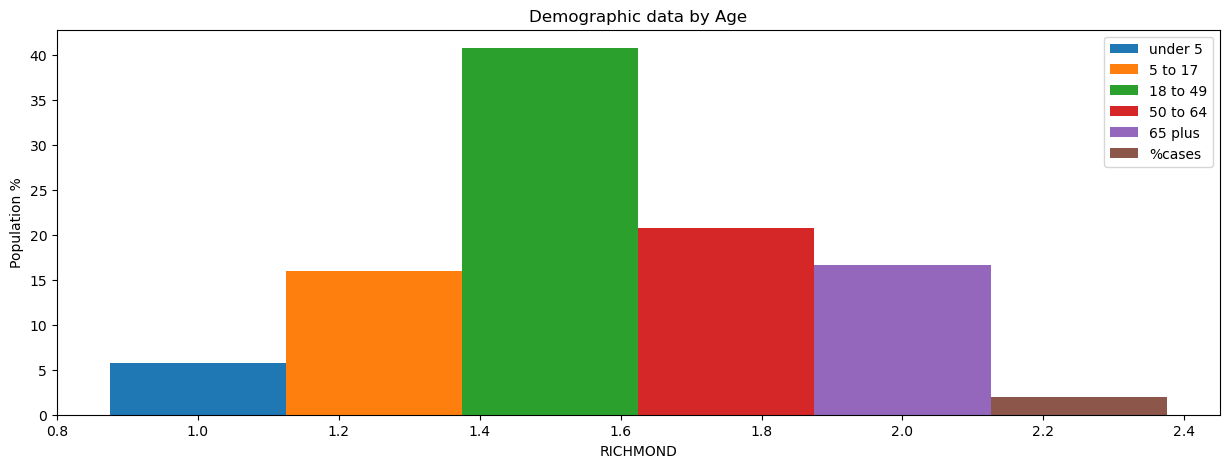

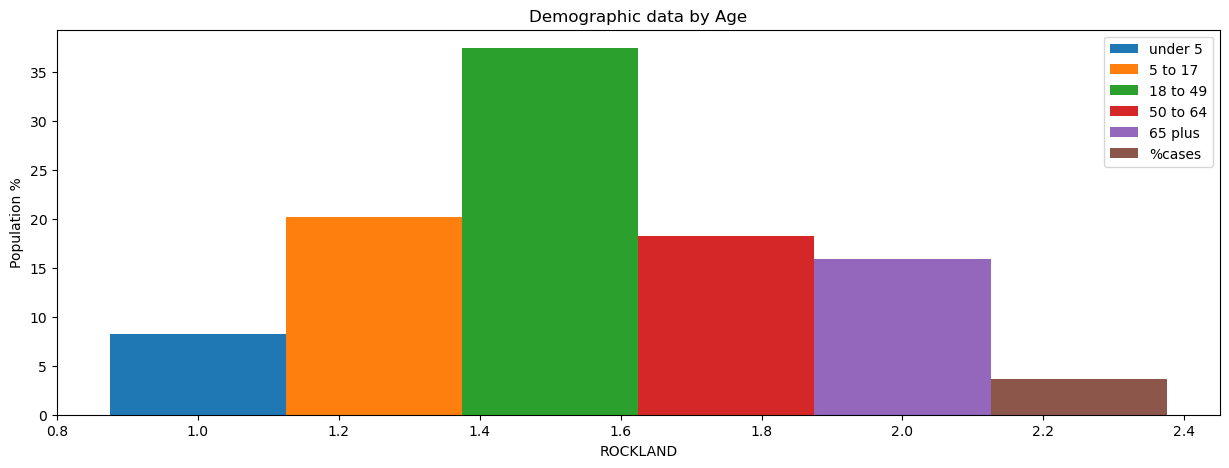

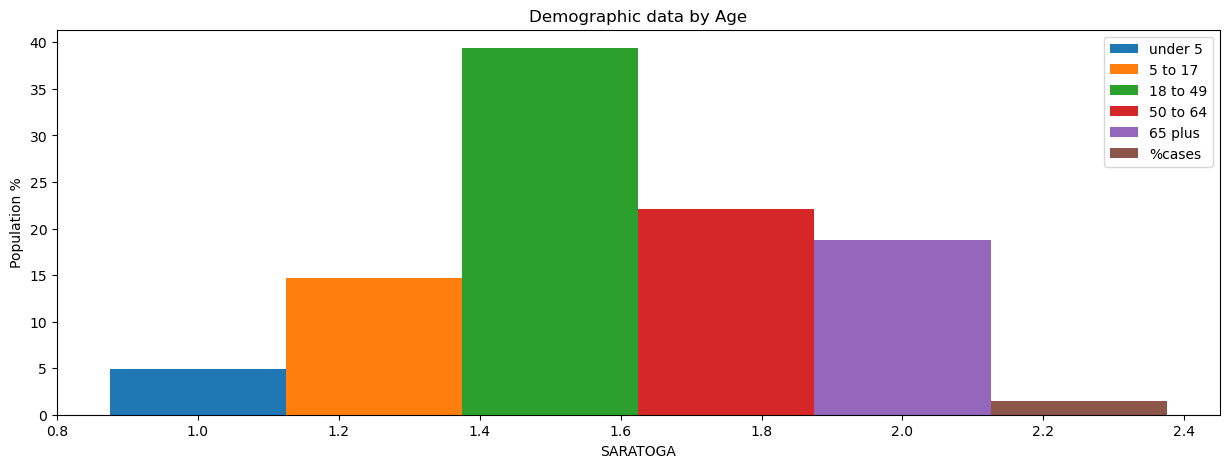

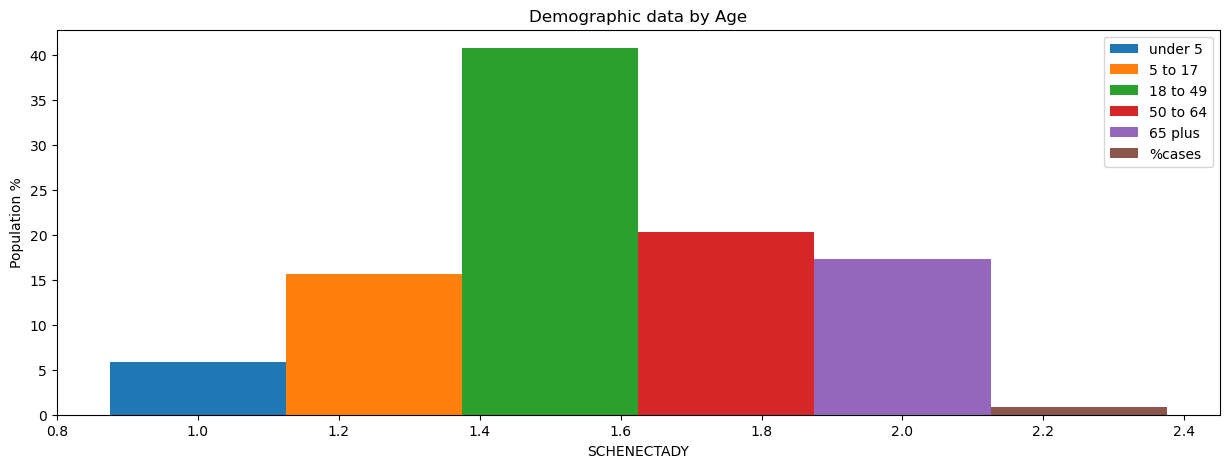

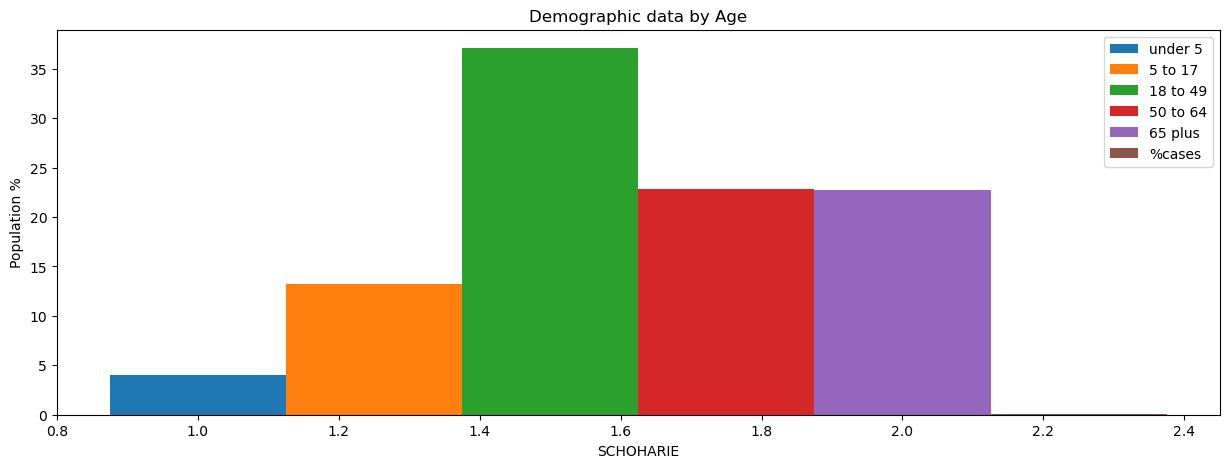

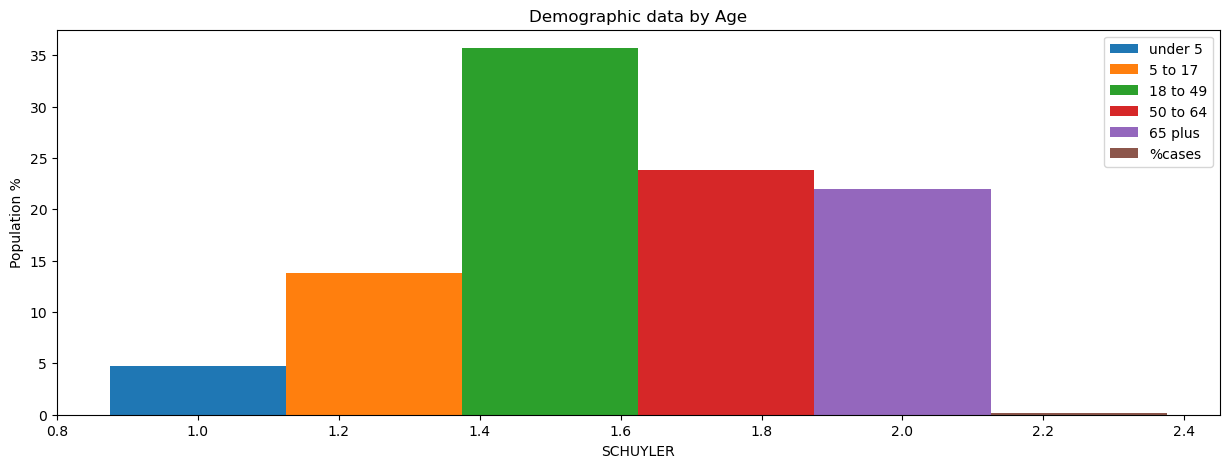

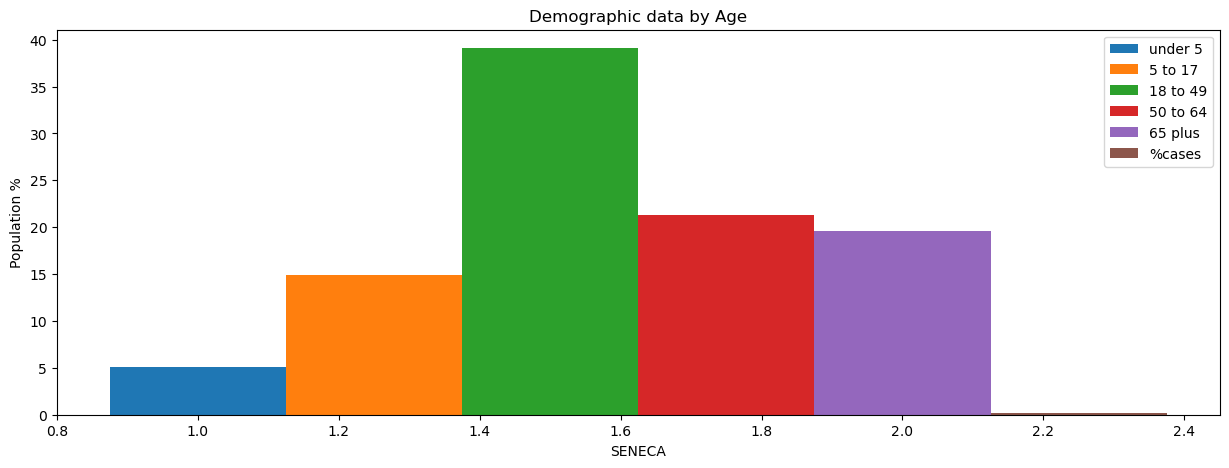

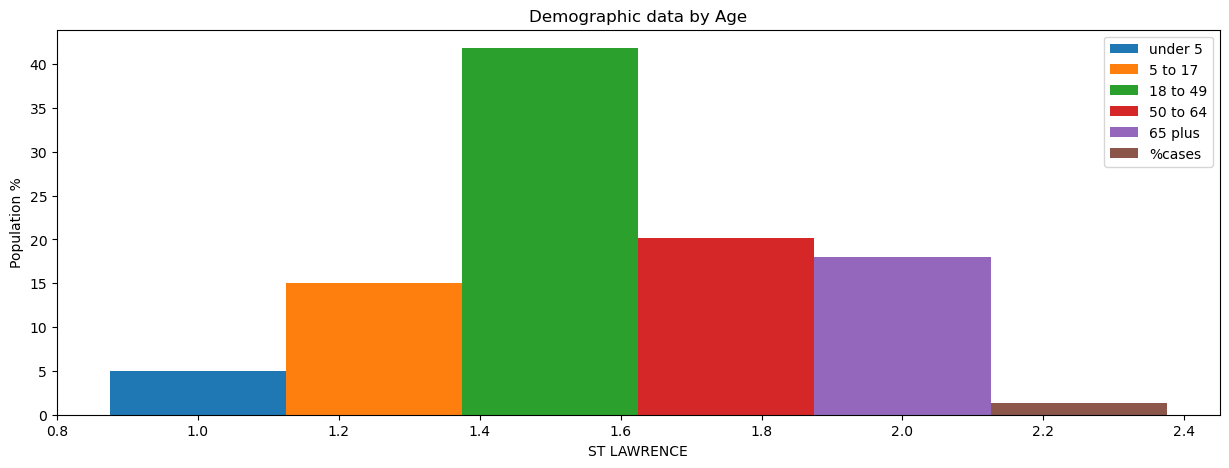

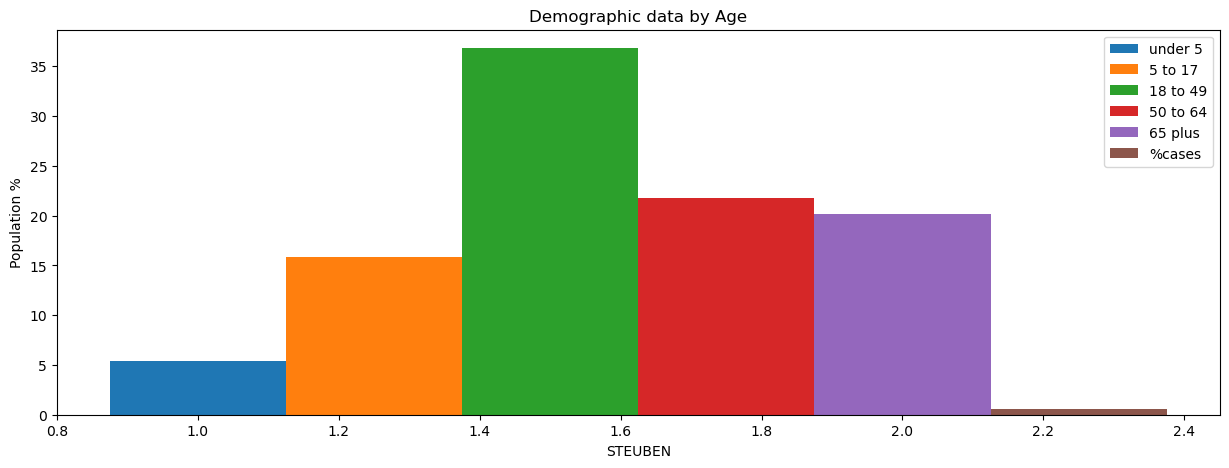

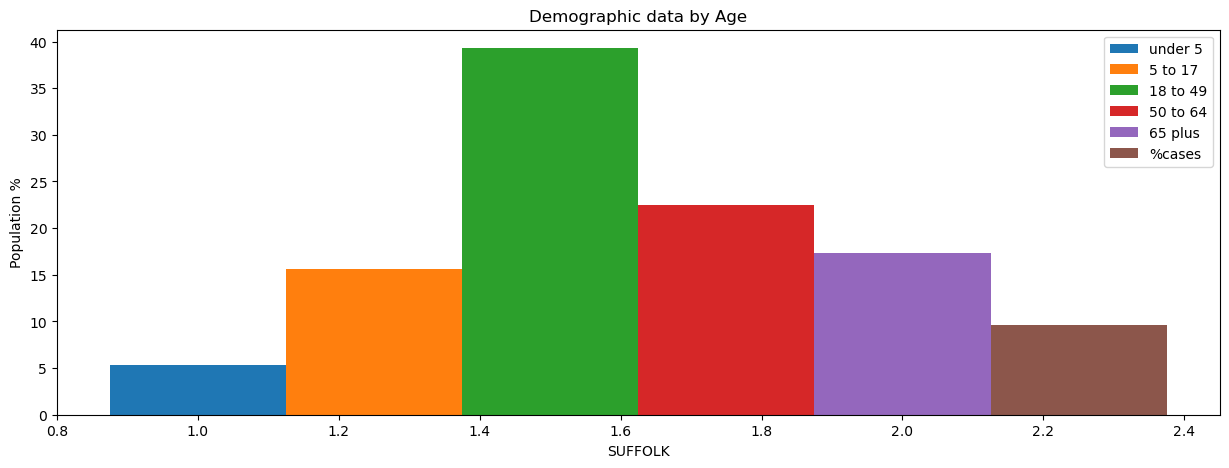

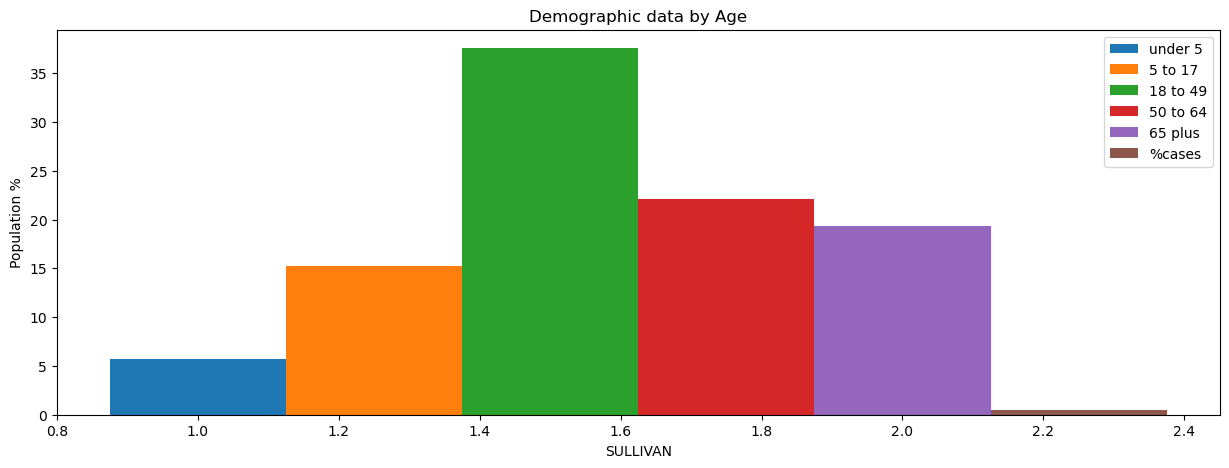

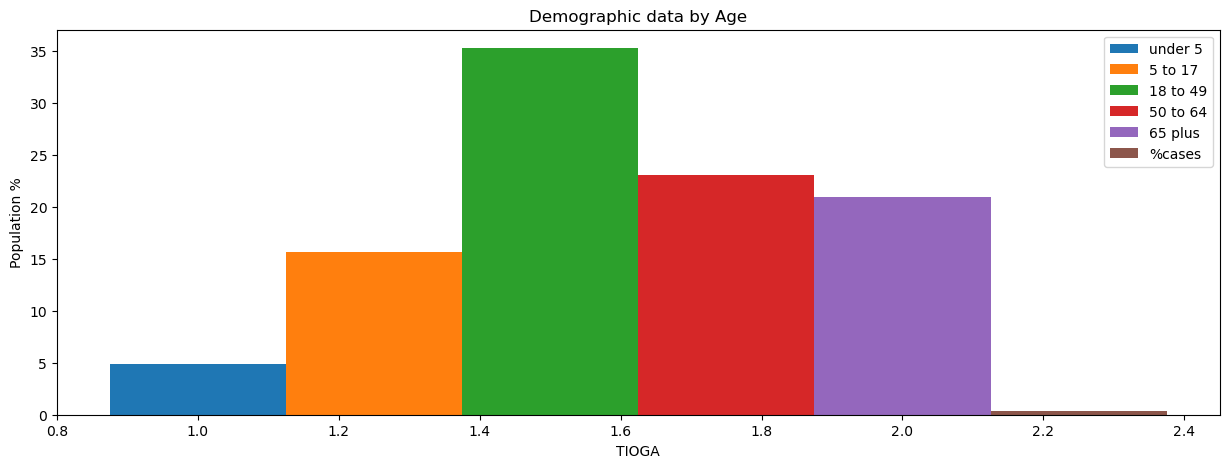

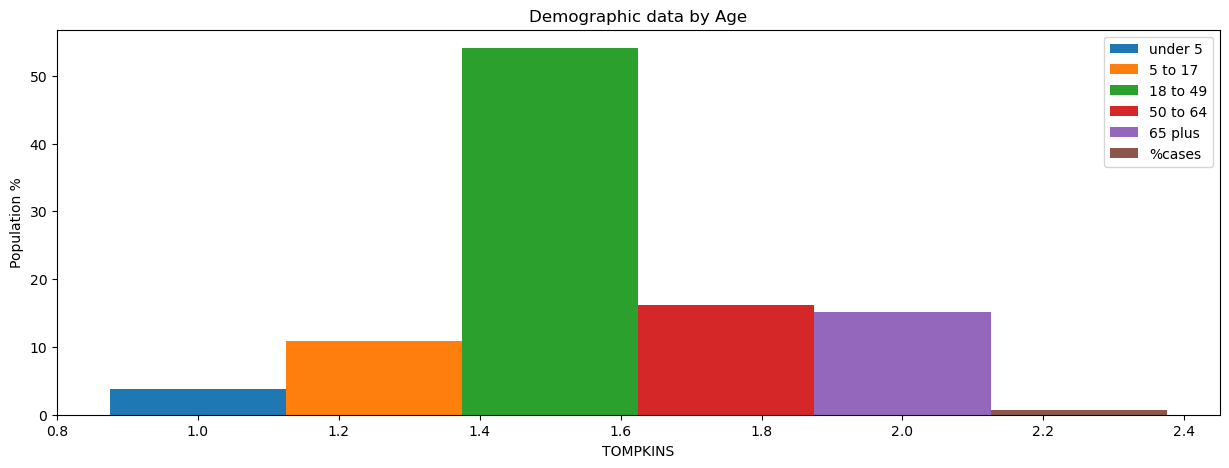

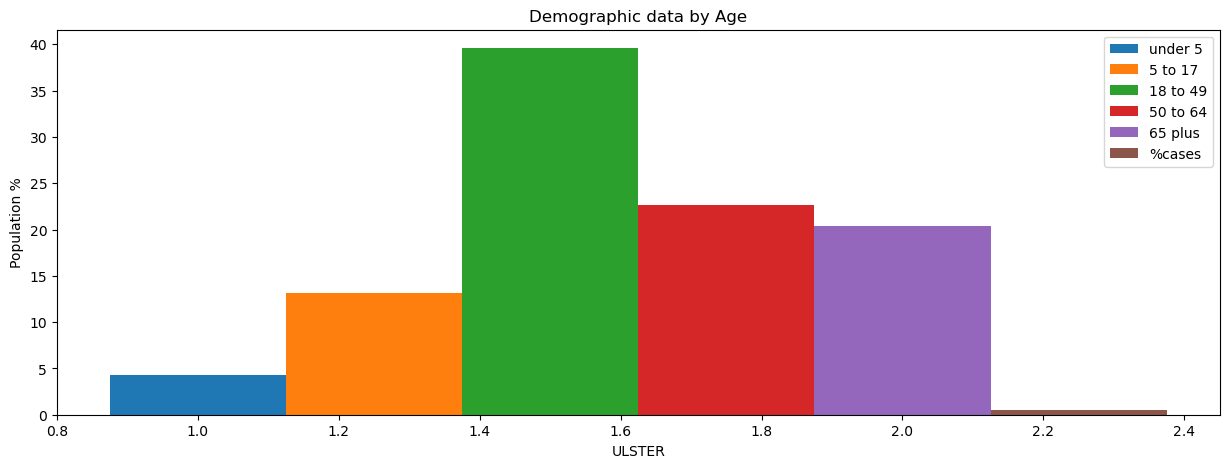

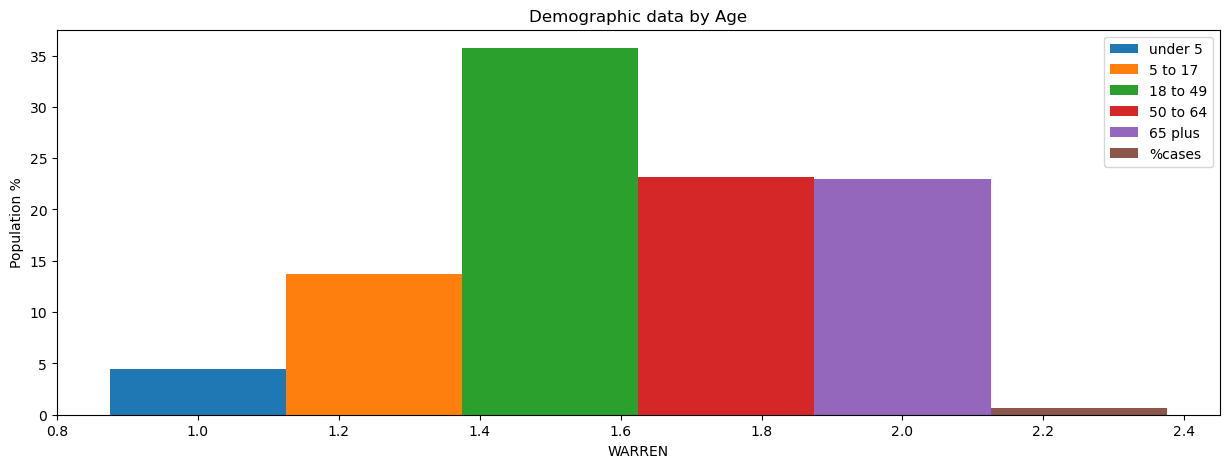

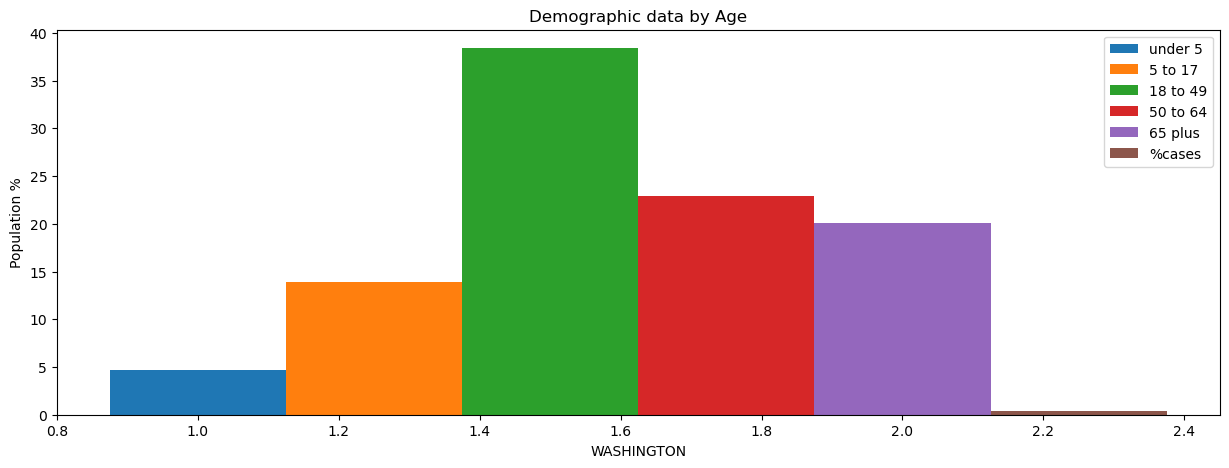

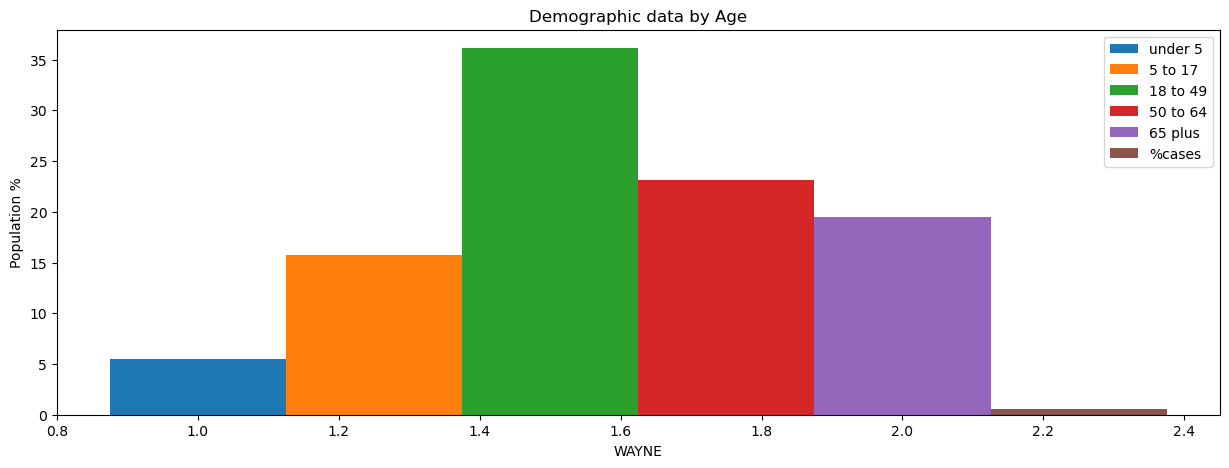

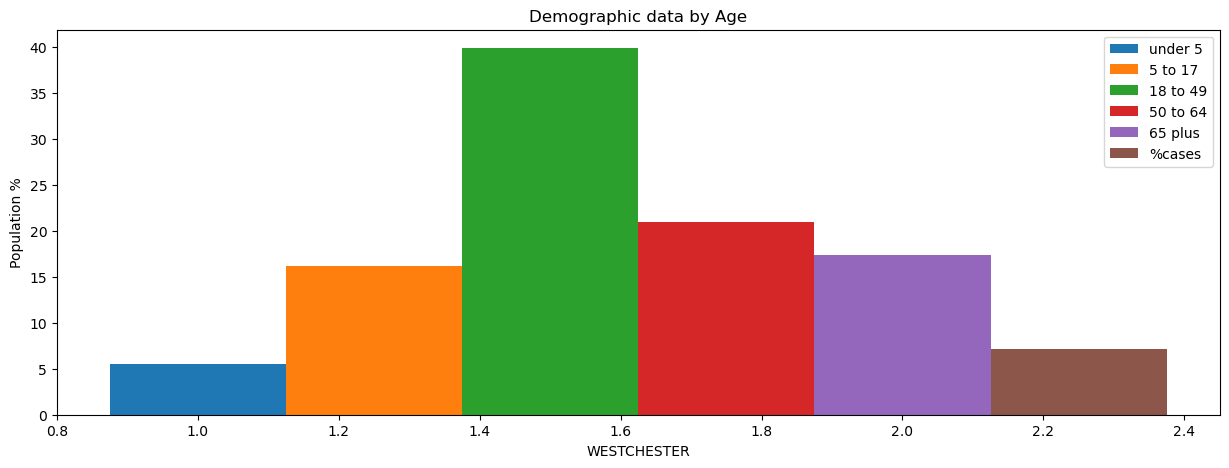

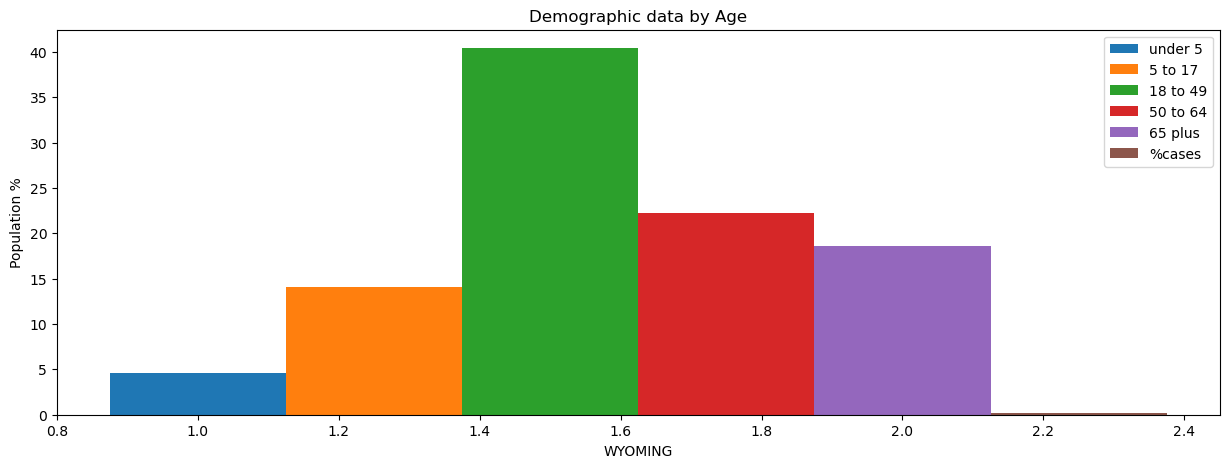

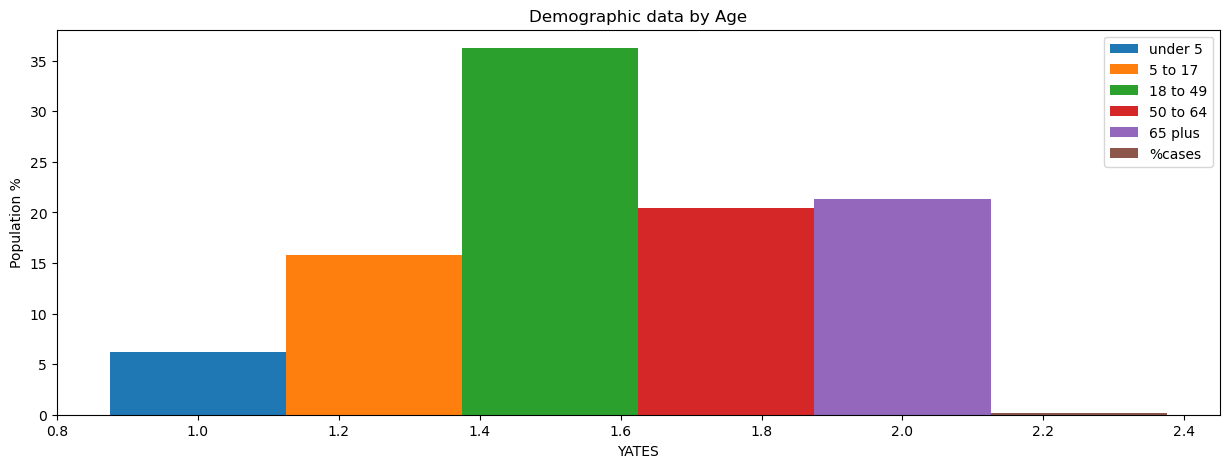

In [61]:
#population demographic graphs for each county
X = corr['County'].to_list()
#X=['ALBANY']
Y = corr['pop_04'].to_list()
A = corr['pop_517'].to_list()
B = corr['pop_1849'].to_list()
C = corr['pop_5064'].to_list()
Z = corr['pop_65plus'].to_list()

for county in X: 
    X_axis = 1
    # Plot the bars
    plt.figure(figsize=(15,5))
    plt.bar(X_axis, corr[corr['County']==county]['pop_04']/corr[corr['County']==county]['pop_est']*100, 0.25, label = 'under 5')
    plt.bar(X_axis+0.25, corr[corr['County']==county]['pop_517']/corr[corr['County']==county]['pop_est']*100, 0.25, label = '5 to 17')
    plt.bar(X_axis+0.25*2, corr[corr['County']==county]['pop_1849']/corr[corr['County']==county]['pop_est']*100, 0.25, label = '18 to 49')
    plt.bar(X_axis+0.25*3, corr[corr['County']==county]['pop_5064']/corr[corr['County']==county]['pop_est']*100, 0.25, label = '50 to 64')
    plt.bar(X_axis+0.25*4, corr[corr['County']==county]['pop_65plus']/corr[corr['County']==county]['pop_est']*100, 0.25, label = '65 plus')
    plt.bar(X_axis+0.25*5, corr[corr['County']==county]['Cases']/(corr['Cases'].sum())*100, 0.25, label = '%cases')
    
    # Plot the data and clean the labels
    plt.plot()
    plt.xlabel(county)
    plt.ylabel("Population %")
    plt.title("Demographic data by Age")
    plt.legend()
    plt.show()